In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import statsmodels.api as sm

In [12]:
warnings.filterwarnings("ignore")

In [67]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()
    
def plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half):
    plt.figure(figsize=(10, 6))
    plt.scatter(column.index, column, label='Original Values')
    plt.plot(column.index, linear_a * column.index + linear_b, color='red', label='Linear Regression')
    plt.plot(column.index, linear_a_half * column.index + linear_b_half, color='green', label='Recent Linear Regression')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.title('Original Values vs. Linear Regression vs. Recent Linear Regression')
    plt.grid(True)
    plt.show()

In [68]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [93]:
# Polynomial Interpolation data inputation method
def four_ends_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        for i in range(4):
            column = first_filler(column, i, len(column) - 1 - i)
            column = last_filler(column, i, len(column) - 1 - i)
    return column

def four_ends_linear_filler(column):
    if  pd.api.types.is_numeric_dtype(column):
        size = len(column) - 1
        column = first_filler(column, 0, size)
        column = last_filler(column, 0, size)
        for i in range(1, 4):
            value = column.at[i]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_first = i - 1
                end_first = next_valid_index(column, i)
                linear_a = (column.at[end_first] - column.at[i - 1])/(end_first - start_first)
                linear_b = column.at[start_first] - linear_a*start_first
                column.at[i] = linear_a*i + linear_b
            x = size - 4 + i
            value = column.at[x]
            if (pd.isnull(value) or np.isnan(value) or (value == '')):
                start_last = prev_valid_index(column, x)
                end_last = next_valid_index(column, x)
                gap = list(range(start_last + 1, end_last))
                linear_a = (column.at[end_last] - column.at[start_last])/(end_last - start_last)
                linear_b = column.at[start_last] - linear_a*start_last
                column.at[x] = linear_a*x + linear_b
    return column

def first_filler(column, init, end):
    if pd.isnull(column.at[init]) or np.isnan(column.at[init]):
        first_valid_index = 0
        while first_valid_index <= end and (pd.isnull(column.at[first_valid_index]) or 
                                             np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > end:
            column.at[init] = 0.0
        else:
            column.at[init] = column.at[first_valid_index]
    return column

def extract_valid_values(column):
    valid_values = []
    valid_indexes = []
    for index, value in enumerate(column):
        if not pd.isnull(value) and not np.isnan(value):
            valid_values.append(value)
            valid_indexes.append(index)
    extracted_column = pd.Series(
        valid_values,
        index=valid_indexes
    )
    return extracted_column

def linear_regression_first_four_filler(column):
    size = len(column) - 1
    processed_column = extract_valid_values(column)
    mean_valid_values_quarter = processed_column.mean()/4
    mean_valid_values_quarter_upper = processed_column.mean() + mean_valid_values_quarter
    
    model = sm.OLS(processed_column, sm.add_constant(processed_column.index))
    result = model.fit()
    linear_a = result.params[1]
    linear_b = result.params['const']
    half_column = processed_column[:(len(processed_column) // 2)]
    model2 = sm.OLS(half_column, sm.add_constant(half_column.index))
    result2 = model2.fit()
    linear_a_half = result2.params[1]
    linear_b_half = result2.params['const']
    
    for i in range(0,4):
        if pd.isnull(column.at[i]) or np.isnan(column.at[i]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[i] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[i] = mean_valid_values_quarter_upper
            else:
                column.at[i] = projected
        x = size - 4 + i
        if pd.isnull(column.at[x]) or np.isnan(column.at[x]):
            projected = ((linear_a*i + linear_b) + (linear_a_half*i + linear_b_half))/2
            if projected < mean_valid_values_quarter:
                column.at[x] = mean_valid_values_quarter
            elif projected > mean_valid_values_quarter_upper:
                column.at[x] = mean_valid_values_quarter_upper
            else:
                column.at[x] = projected
    plot_linear_regression(column, linear_a, linear_b, linear_a_half, linear_b_half)
    return column
    
def last_filler(column, init, end):
    if pd.isnull(column.at[end]) or np.isnan(column.at[end]):
        last_valid_index = len(column) -1
        while last_valid_index >= init and (pd.isnull(column.at[last_valid_index]) or 
                                         np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < init:
            column.at[end] = 0.0
        else:
            column.at[end] = column.at[last_valid_index]
    return column
  
def neareast_four_indexes(column, start, end):
    return prev_four_valid_indexes(column, start) + next_four_valid_indexes(column, end)

def prev_four_valid_indexes(column, pos):
    prev_index = pos
    index_prev_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_prev_list[3 - i] = prev_index
            prev_index -= 1
            while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
                prev_index -= 1
    return index_prev_list  

def next_four_valid_indexes(column, pos):
    next_index = pos
    index_next_list = [0]*4
    size = len(column) - 1
    if pos > 0 and pos < size:
        for i in range(4):
            index_next_list[i] = next_index
            next_index += 1
            while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
                next_index += 1
    return index_next_list  

def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        prev_index -= 1
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos >= 0 and pos < size:
        next_index += 1
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def interpolating_polynomial(nearest_indexes, nearest_values):
    coeffs = np.polyfit(nearest_indexes, nearest_values, 3)
    return np.poly1d(coeffs)

def polynomial_filler(column):
    size = len(column) -1
    if column.isnull().any() and column.isna().any():
        for i, value in enumerate(column):
            if (i > 3 and i < size - 3) and (pd.isnull(value) or np.isnan(value) or (value == '')):
                nearest_values = []
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                nearest_indexes = neareast_four_indexes(column, start, end)
                for index in nearest_indexes:
                    nearest_values.append(column.at[index])
                polynomial = interpolating_polynomial(nearest_indexes, nearest_values)
                for x in gap:
                    column.at[x] = polynomial(x)
                plot_polynomial(polynomial, nearest_indexes[0], nearest_indexes[len(nearest_indexes) - 1], 50, gap, nearest_indexes, column.name)
    return column

def plot_polynomial(polynomial, start, end, precision, interpolated_list, nearest_indexes, column_name):
    x = np.linspace(start, end, precision)
    y = polynomial(x)

    plt.figure()

    plt.plot(x, y)

    interpolated_x = interpolated_list  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='red')
    interpolated_x = nearest_indexes  
    interpolated_y = polynomial(interpolated_x)
    plt.scatter(interpolated_x, interpolated_y, color='green')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(column_name)

    plt.show()
    
def replace_negative_with_float_zeros(x):
    return 0.0 if x < 0 else x

In [94]:
def read_csv_replace_missing_by_polynomial(file_path, skiped_rows, skiped_columns):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > skiped_columns:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = linear_regression_first_four_filler(df[col])
                df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
                df[col] = polynomial_filler(df[col])
                df[col] = df[col].apply(replace_negative_with_float_zeros)
            i += 1
        return df

In [95]:
# Set display options to show all rows and columns
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# df = pd.read_csv('dados_imobilidarios_bcb.csv')
# df.index = pd.to_datetime(df.iloc[:, 0])
# df = df.iloc[:, 1:]
# new_dates = pd.date_range(start='31/01/2008', periods=12*6, freq='M')
# new_df = pd.DataFrame(index=new_dates, columns=df.columns)
# new_df = new_df.fillna(np.nan)
# df = pd.concat([new_df, df])
# df.to_csv('dados_imobilidarios_bcb_extrapolados_2008.csv')

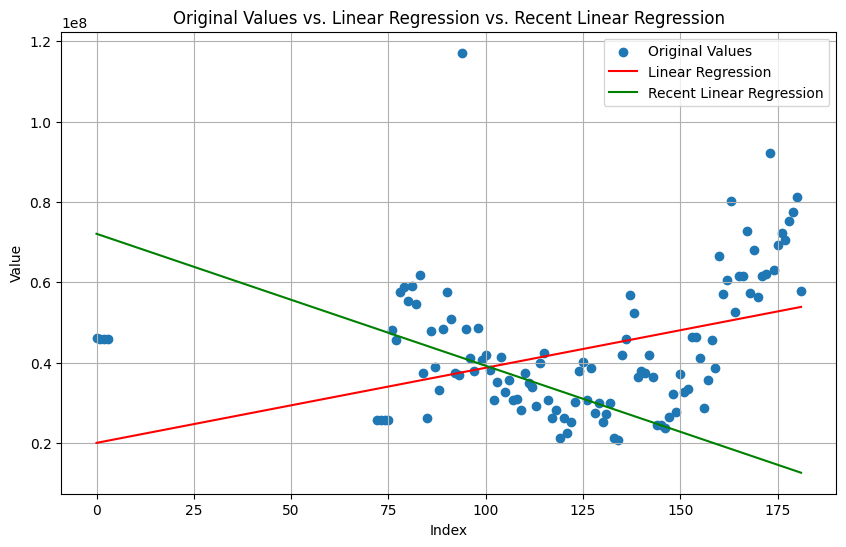

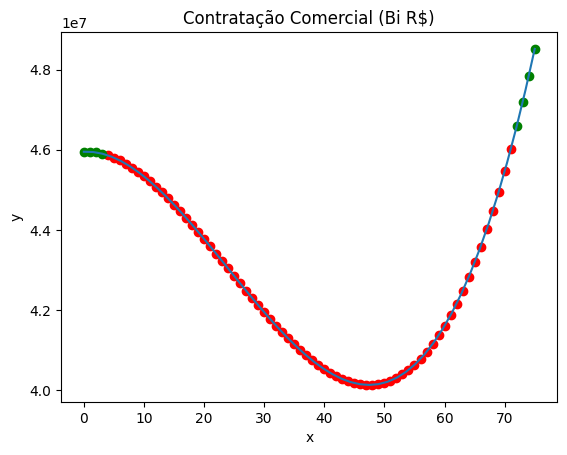

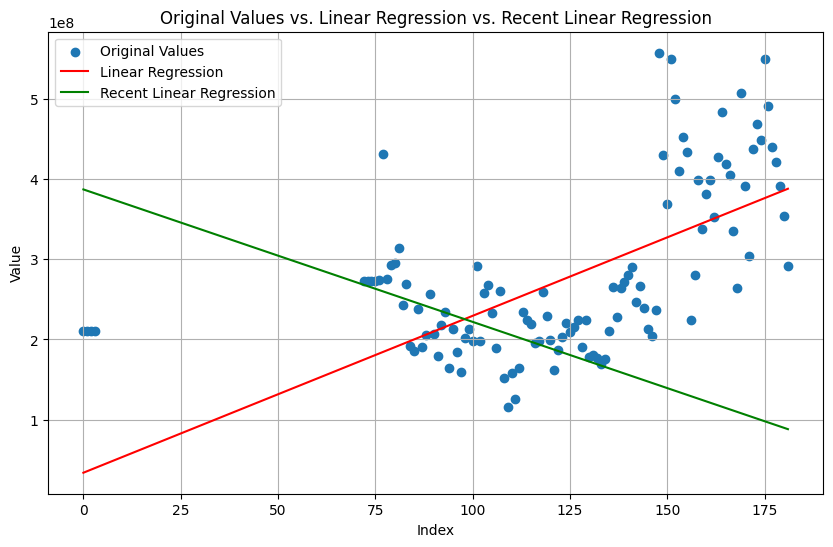

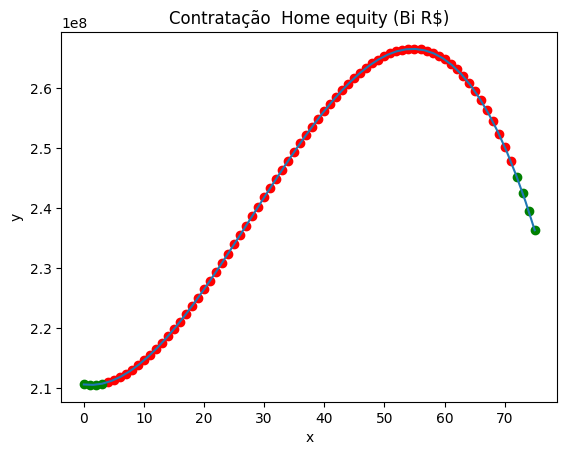

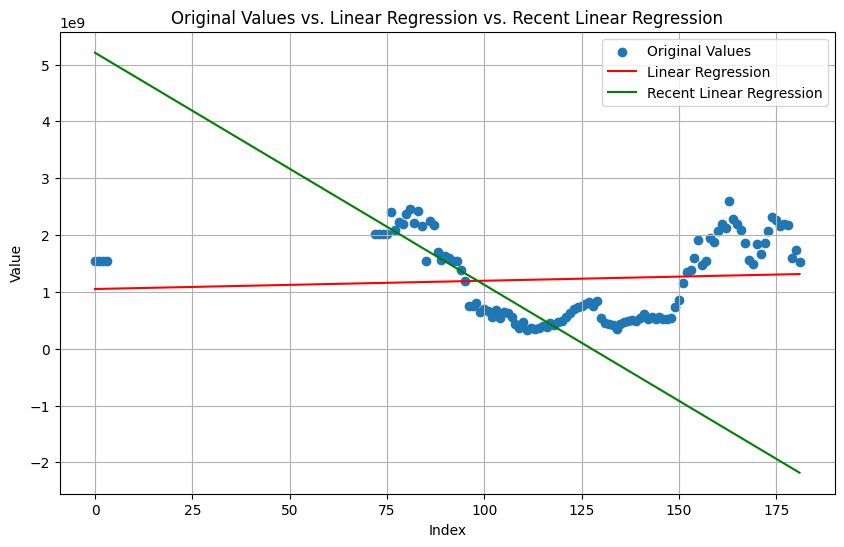

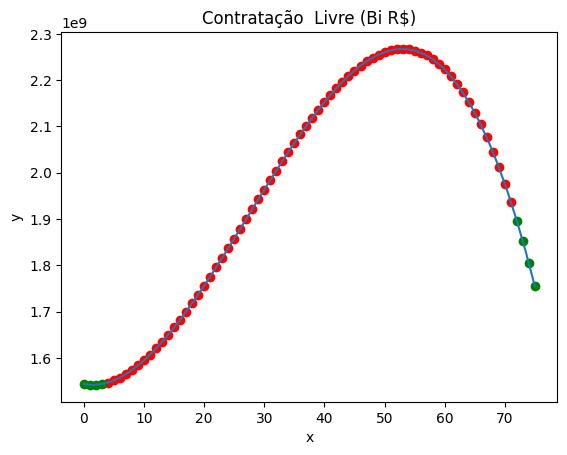

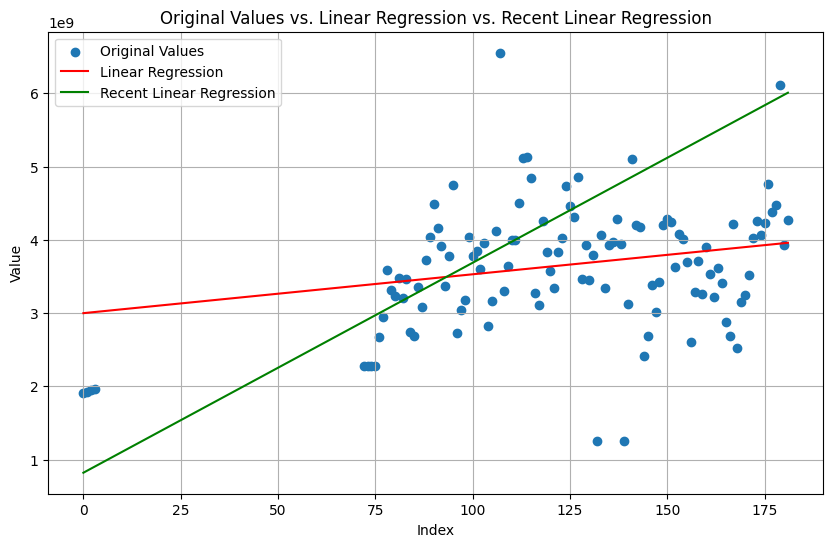

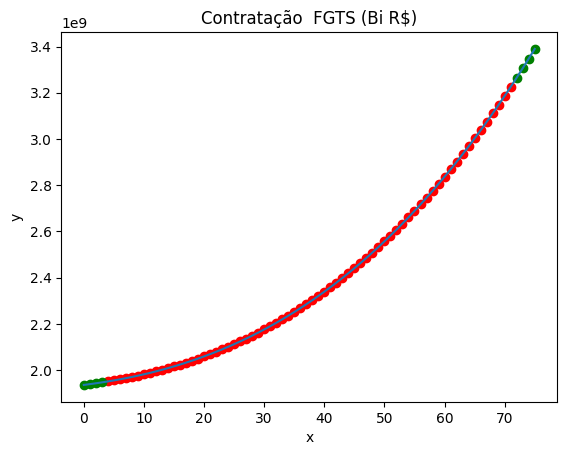

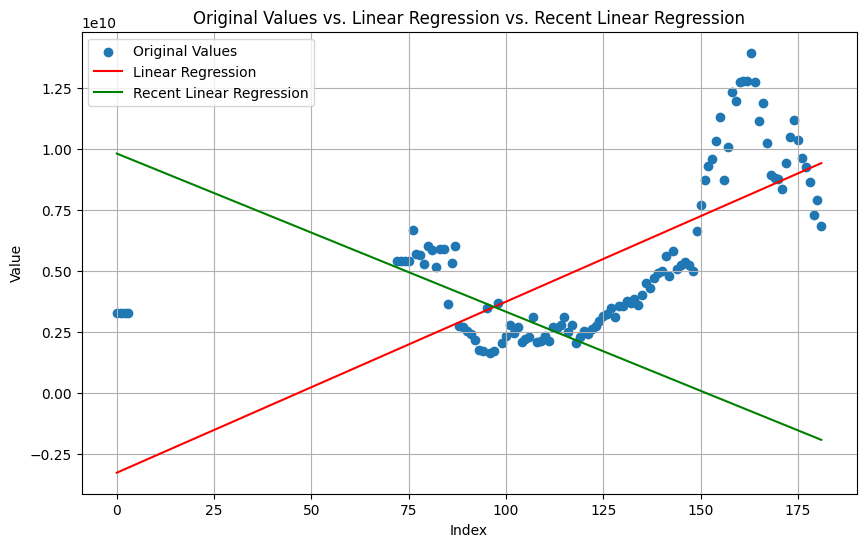

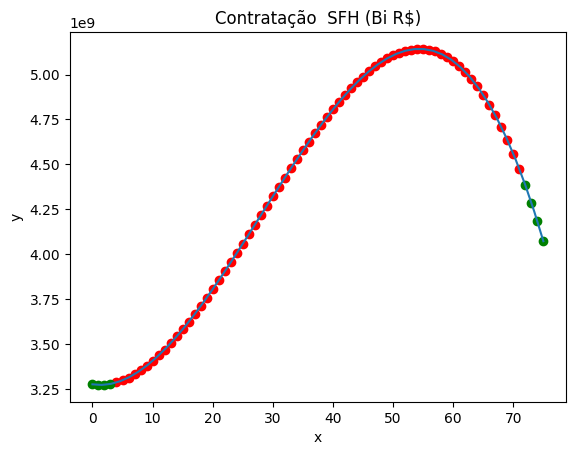

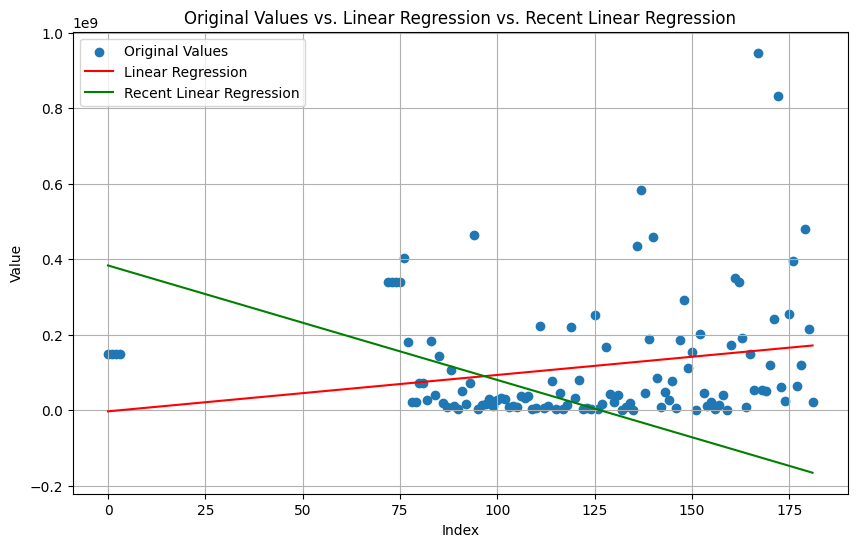

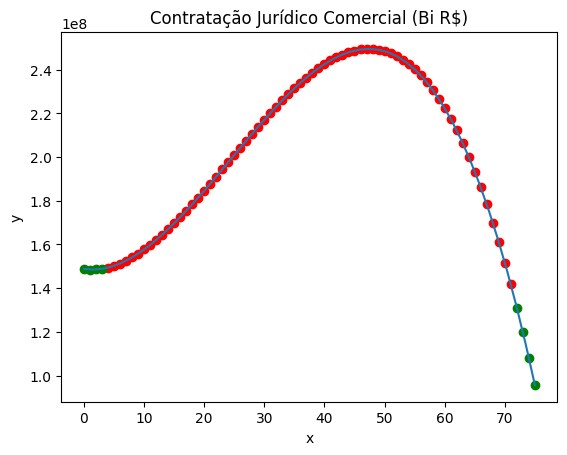

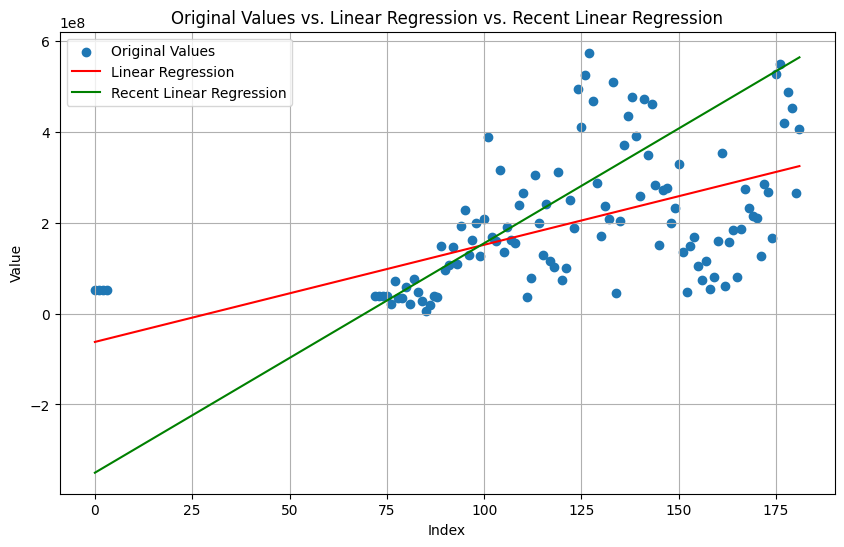

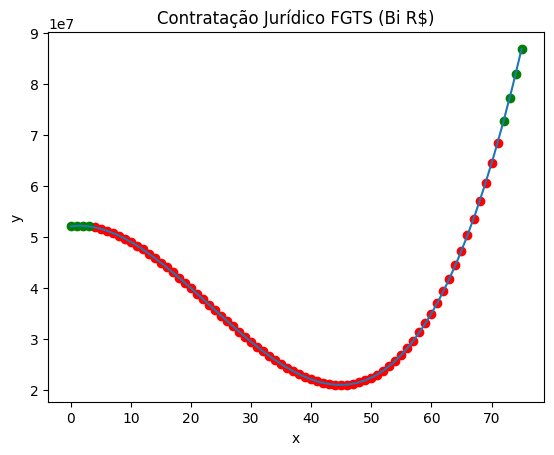

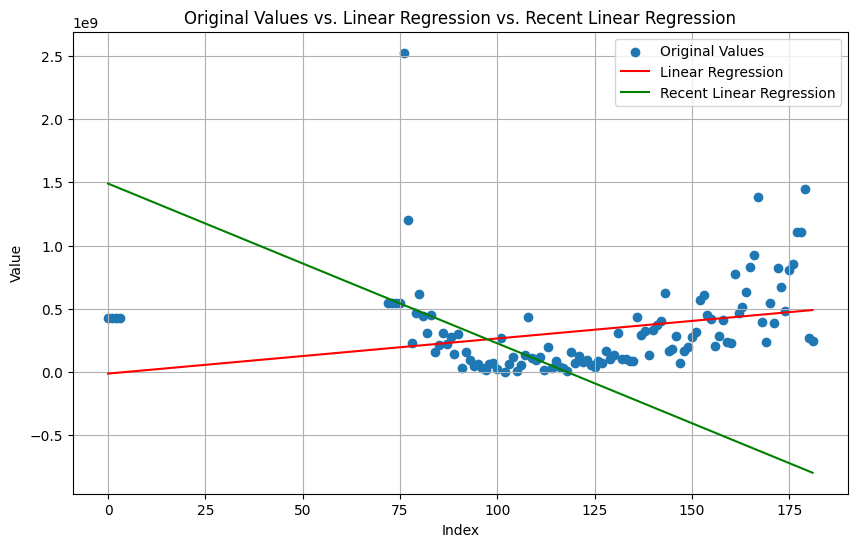

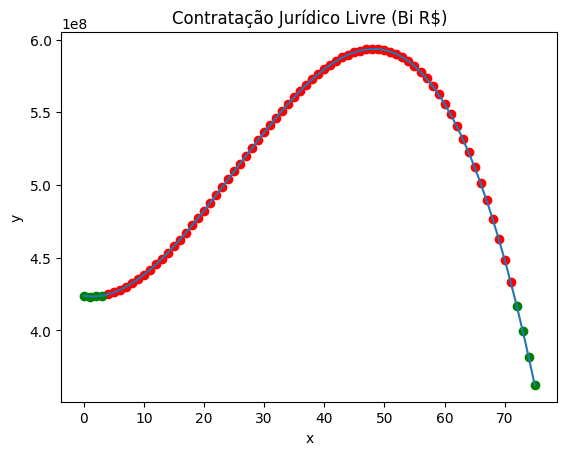

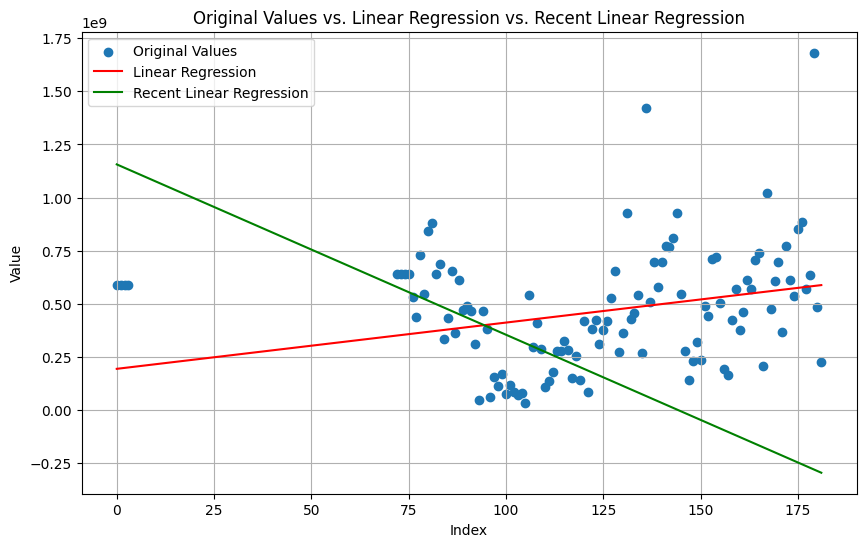

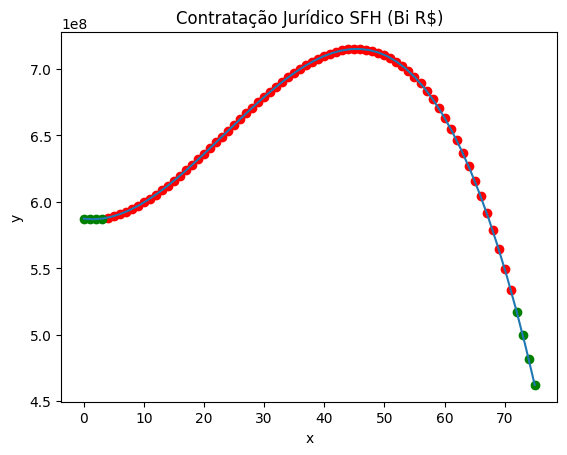

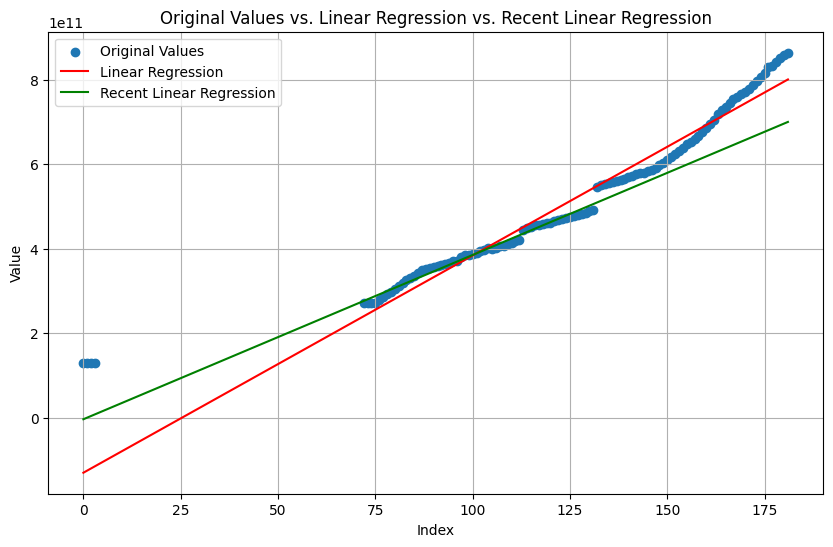

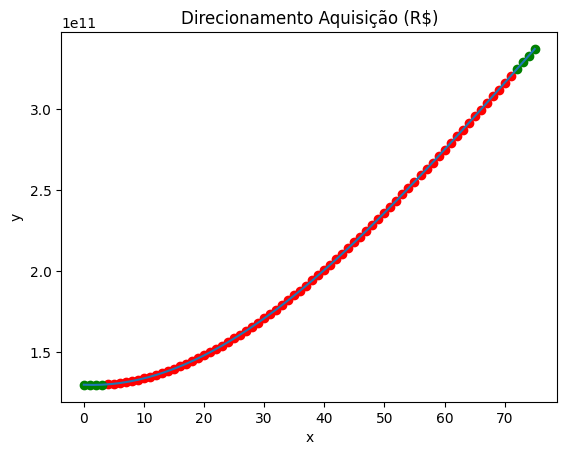

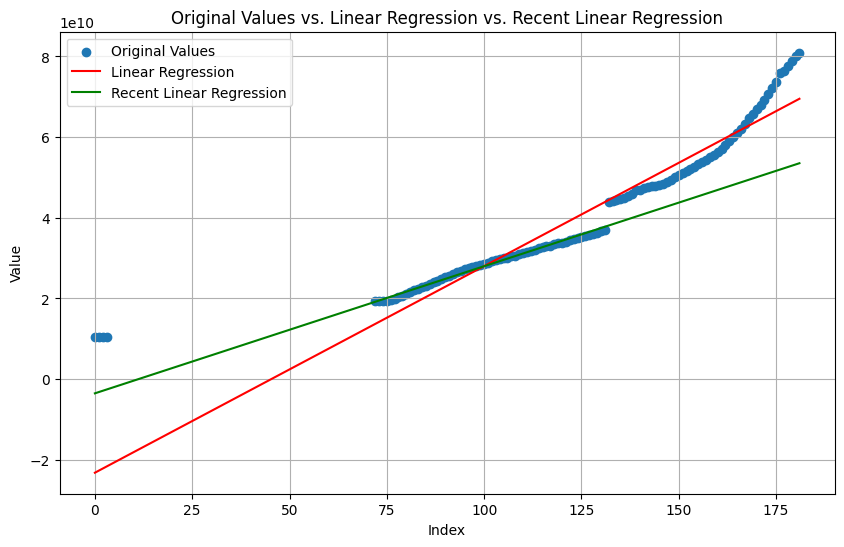

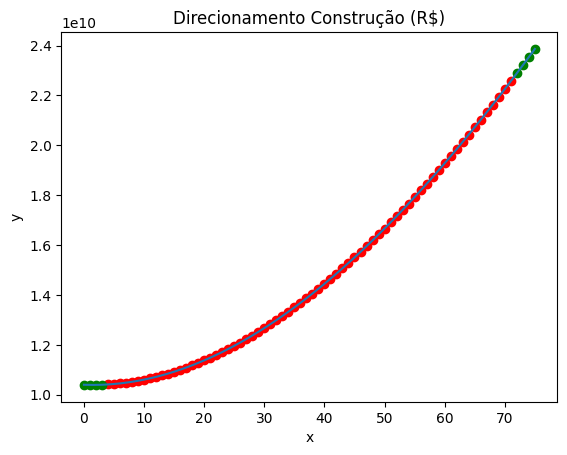

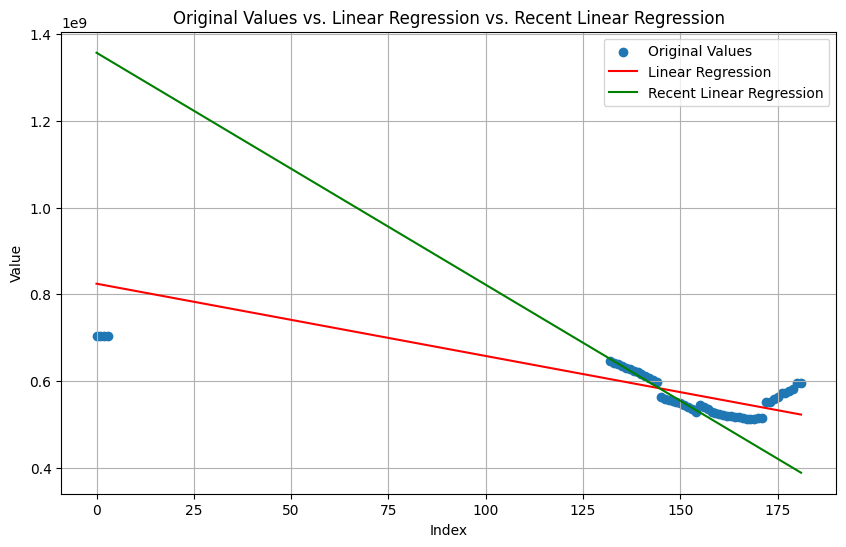

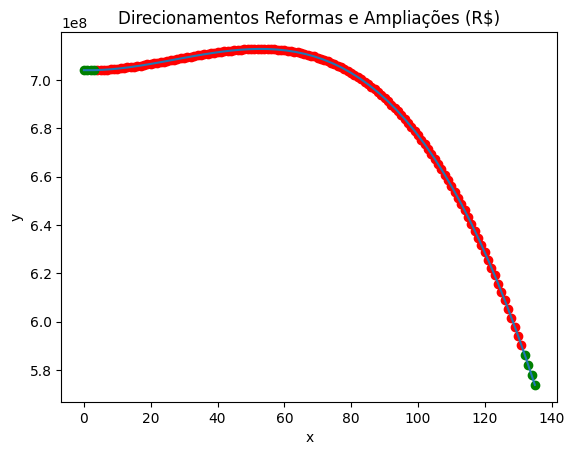

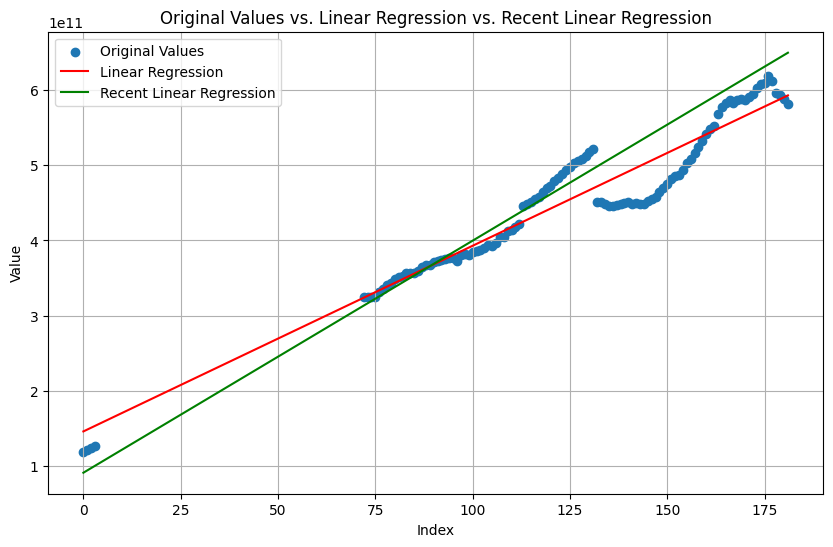

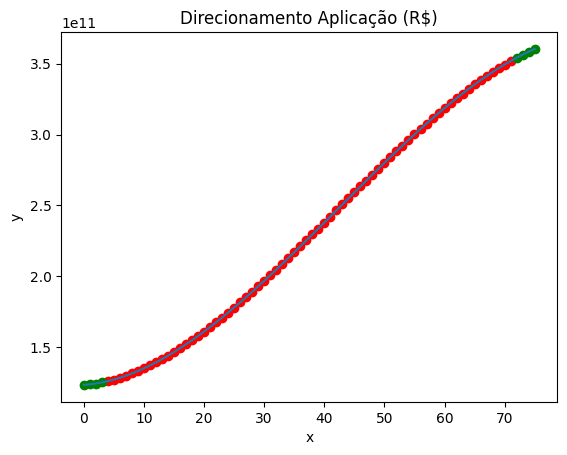

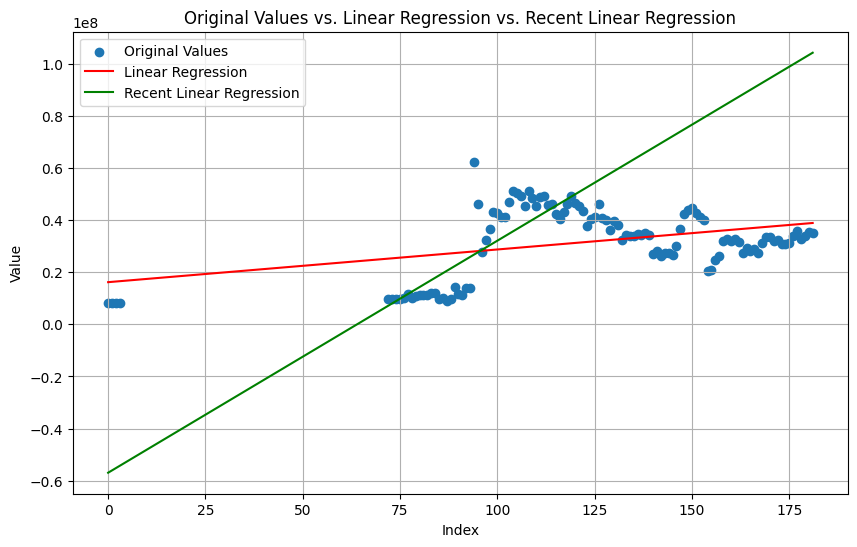

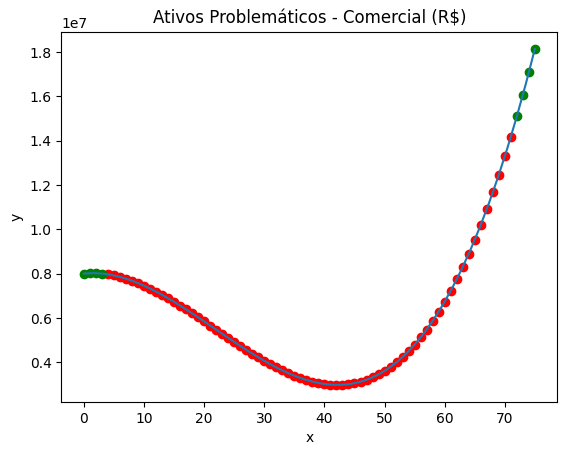

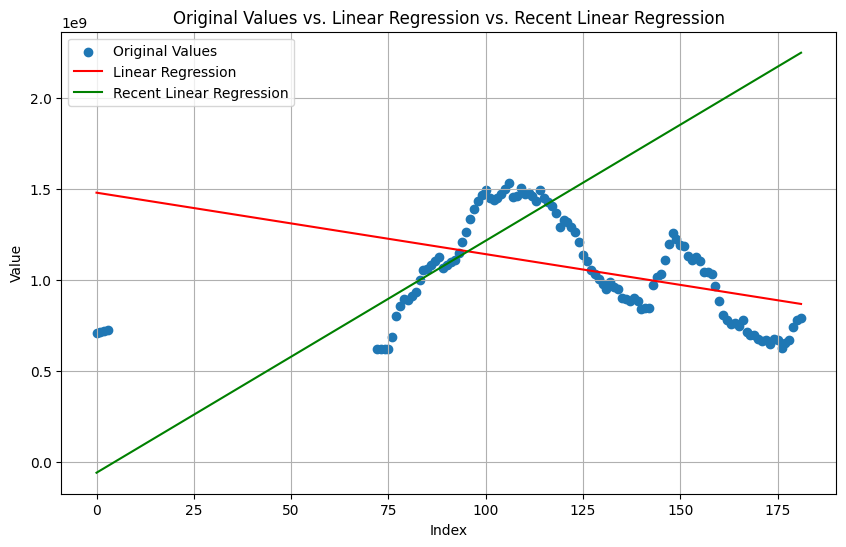

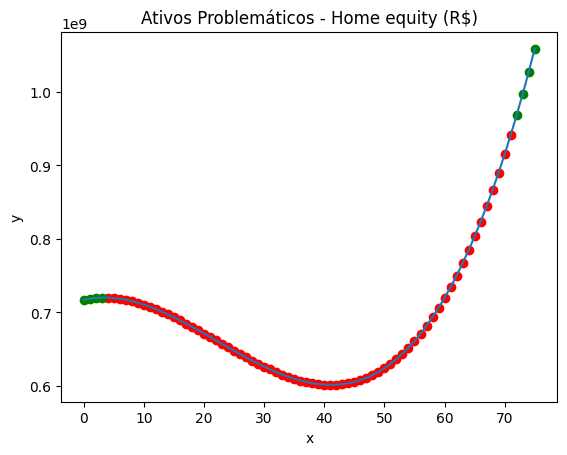

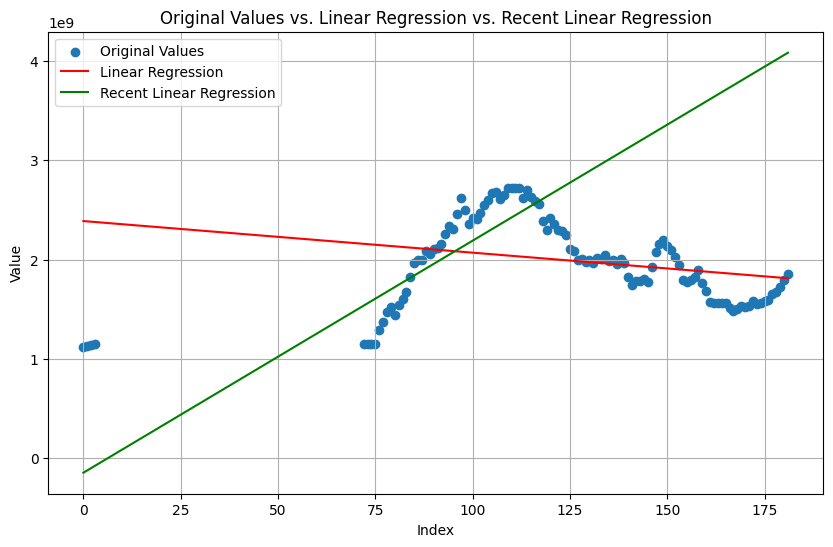

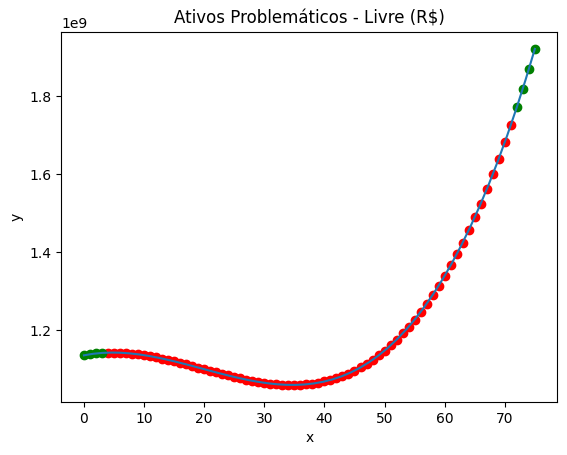

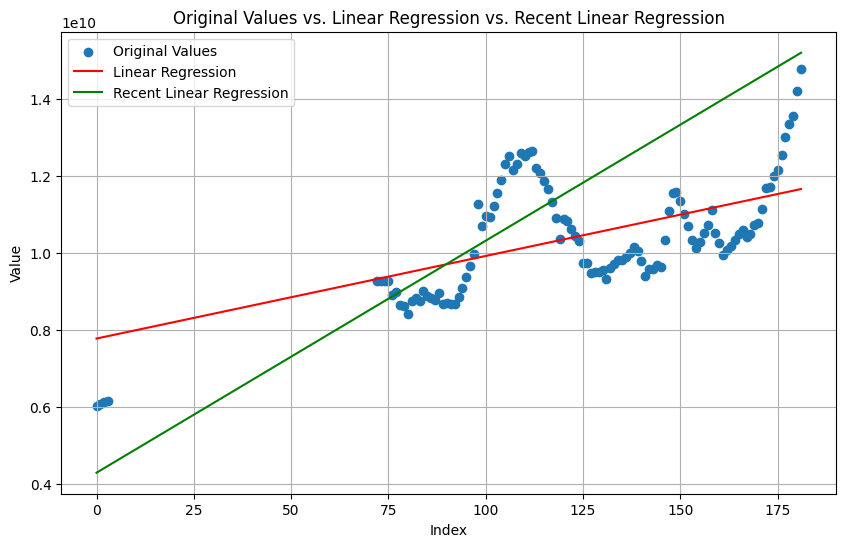

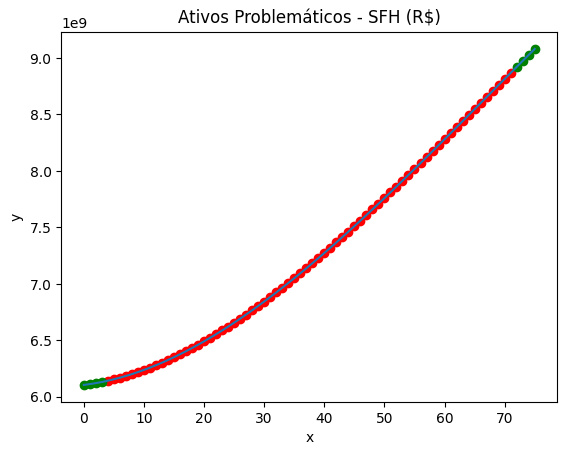

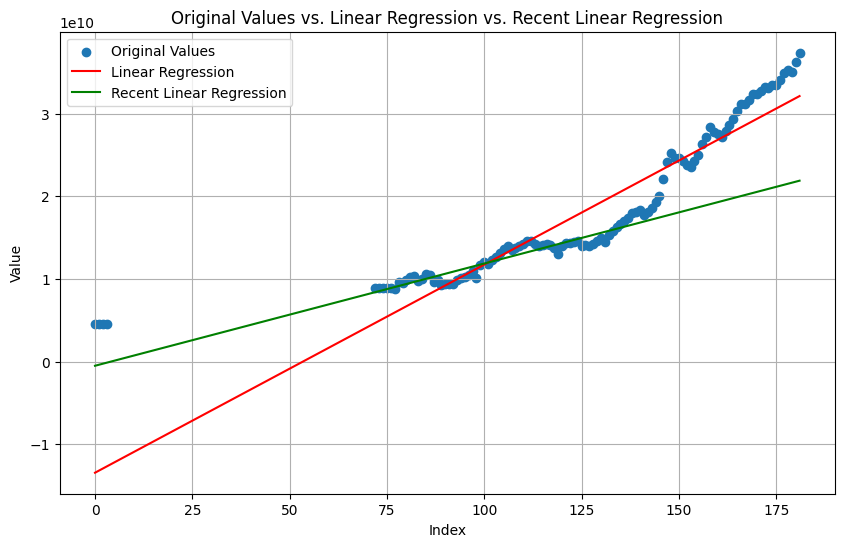

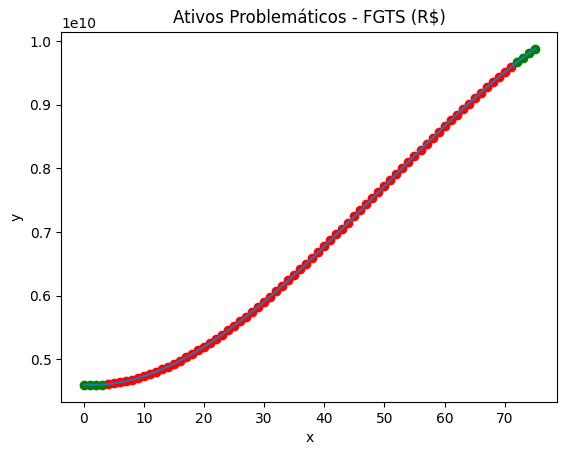

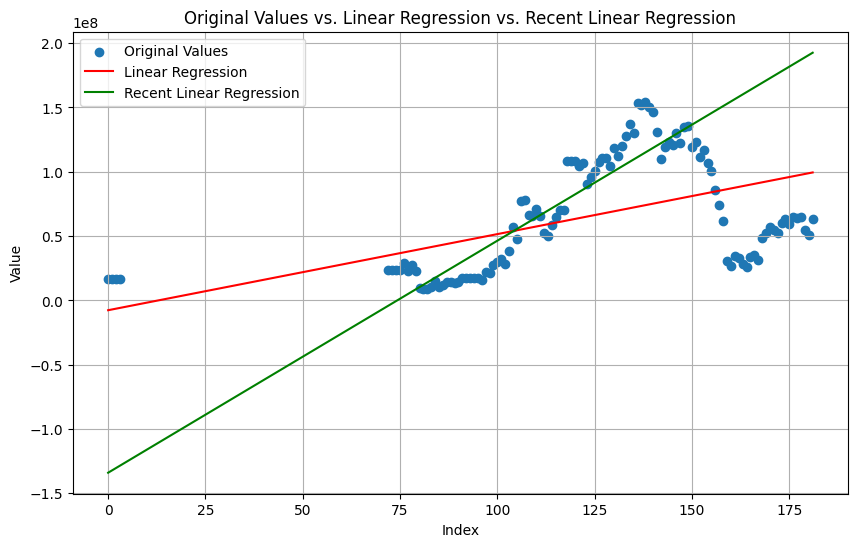

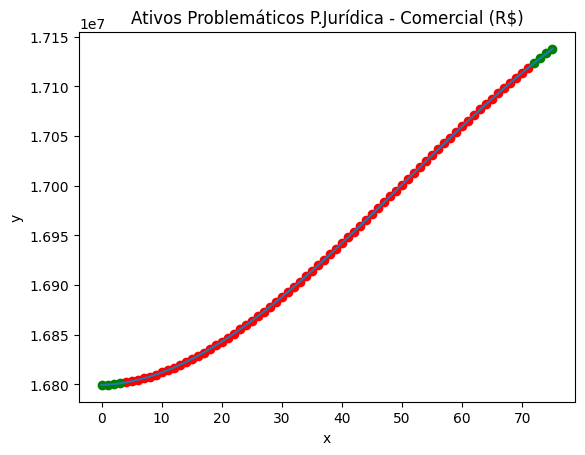

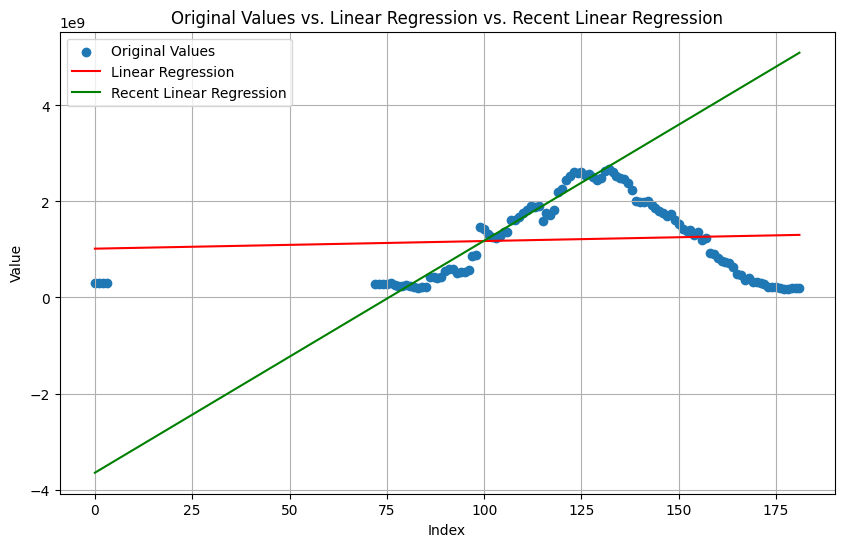

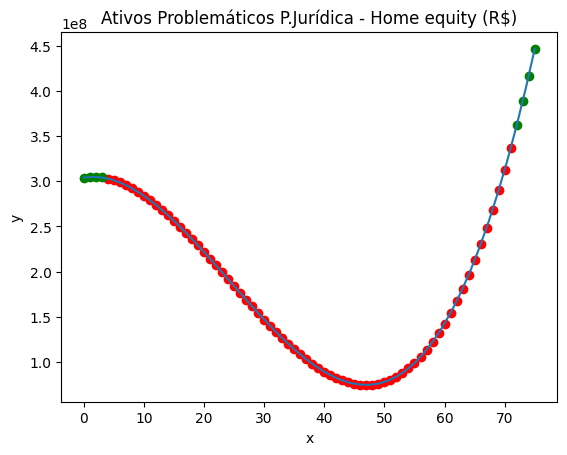

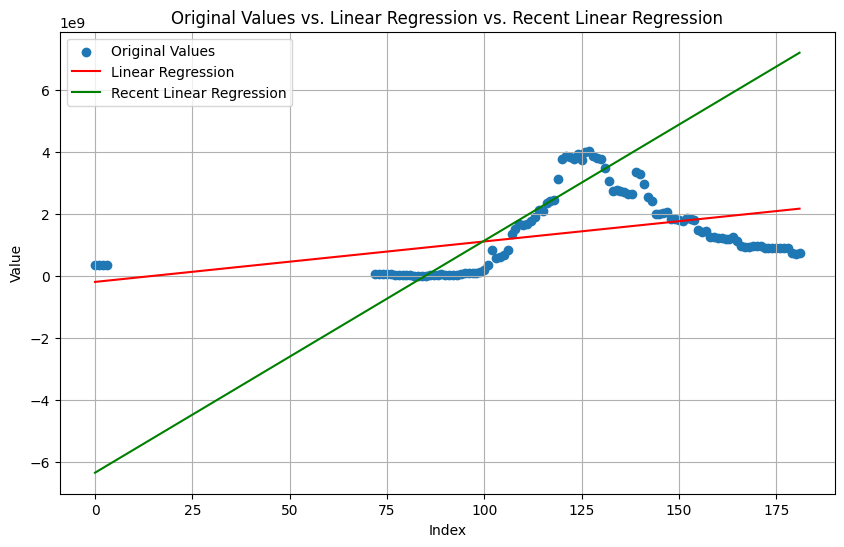

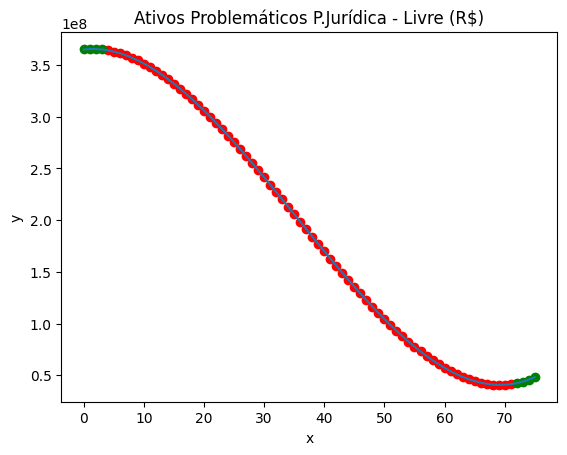

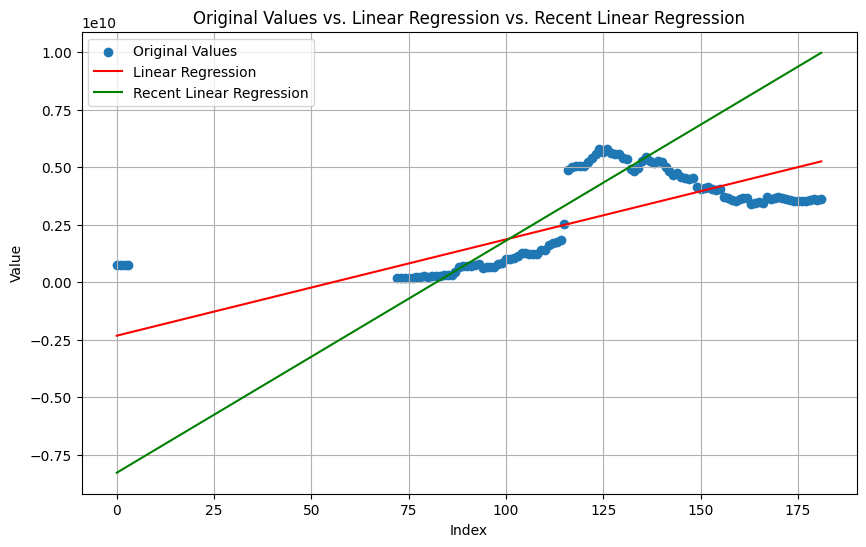

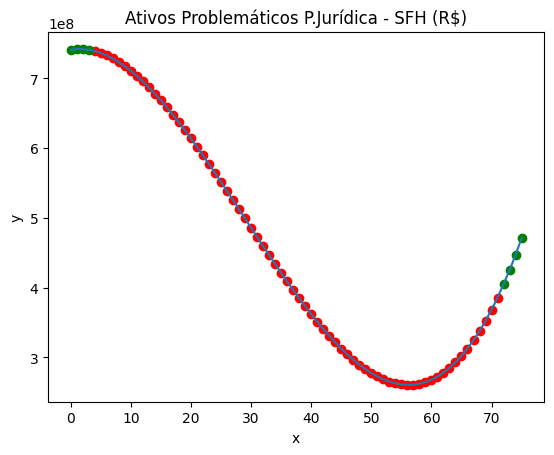

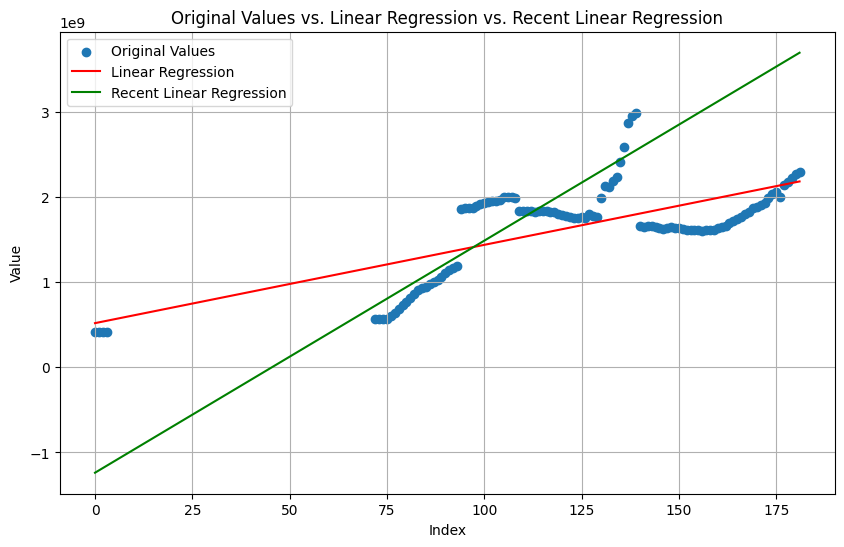

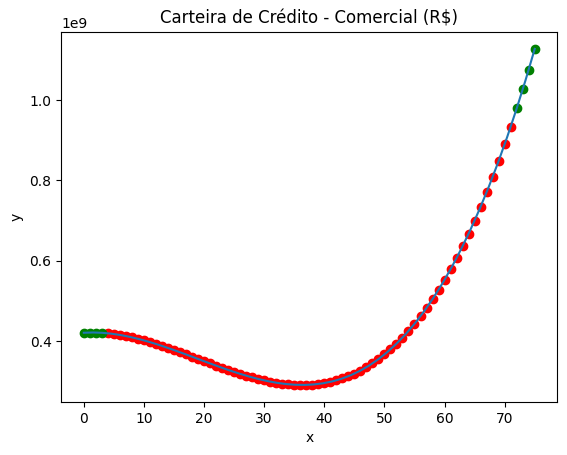

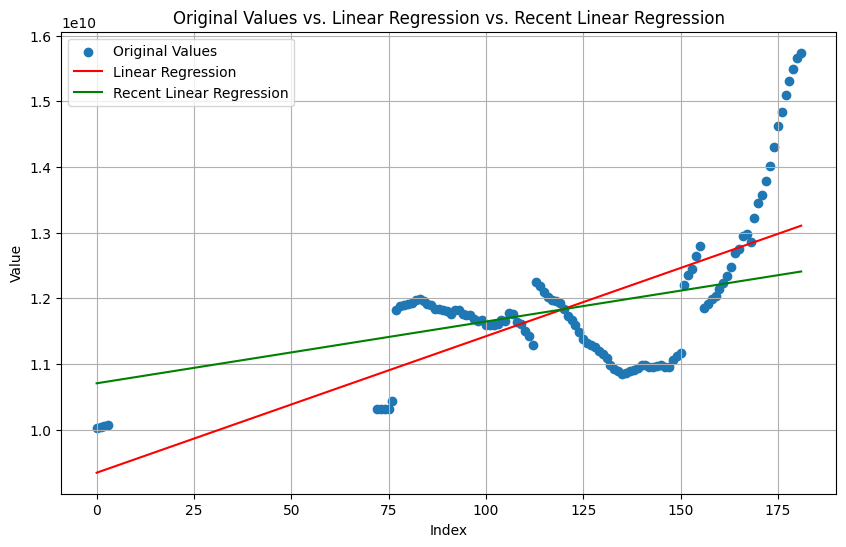

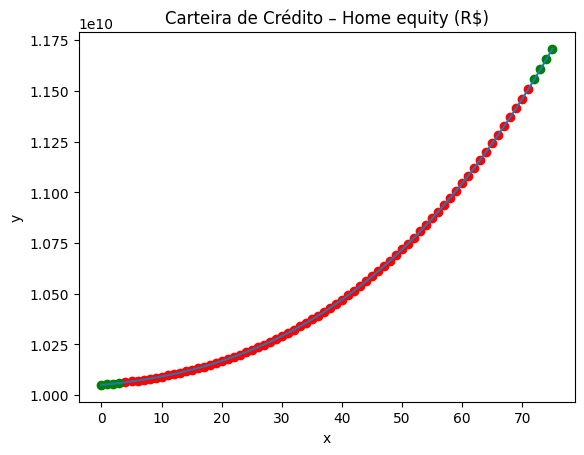

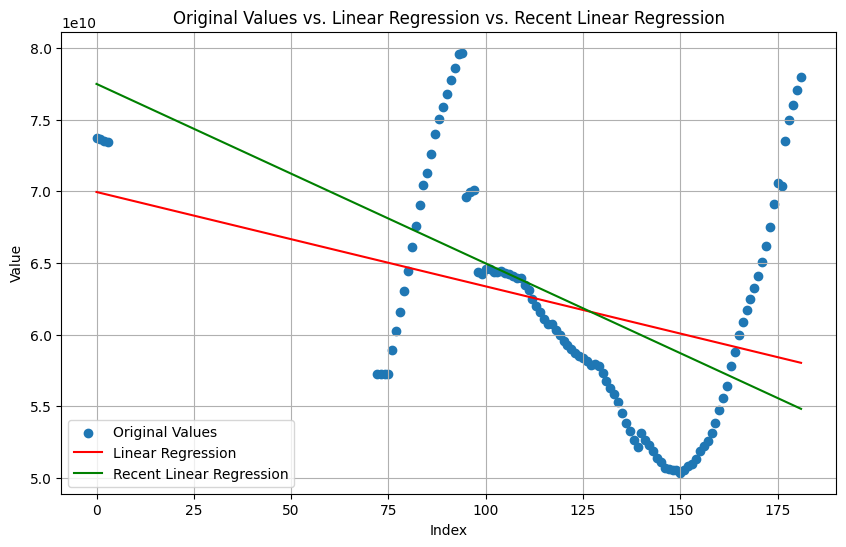

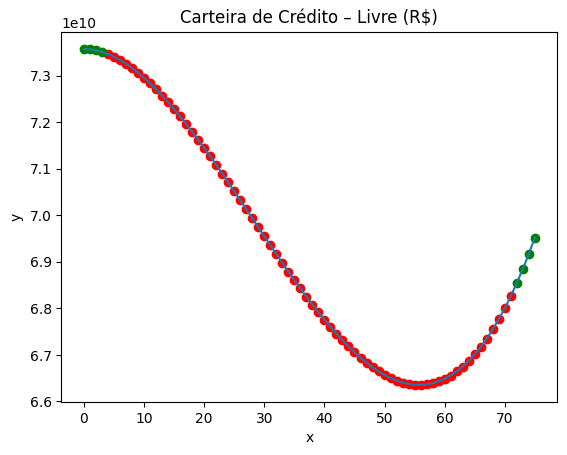

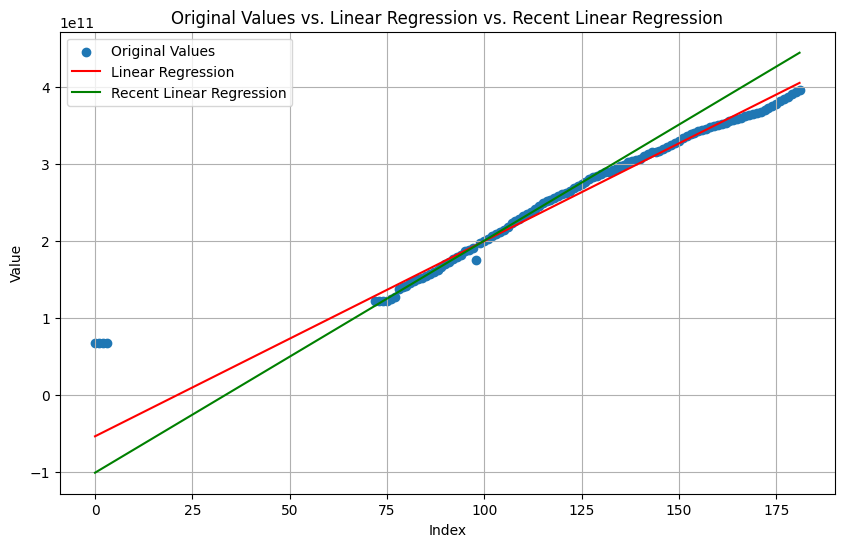

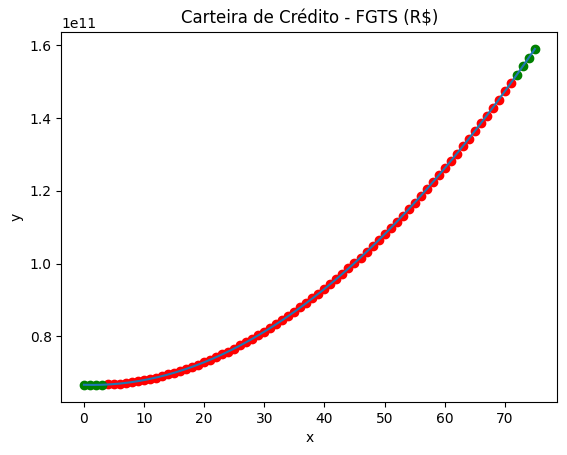

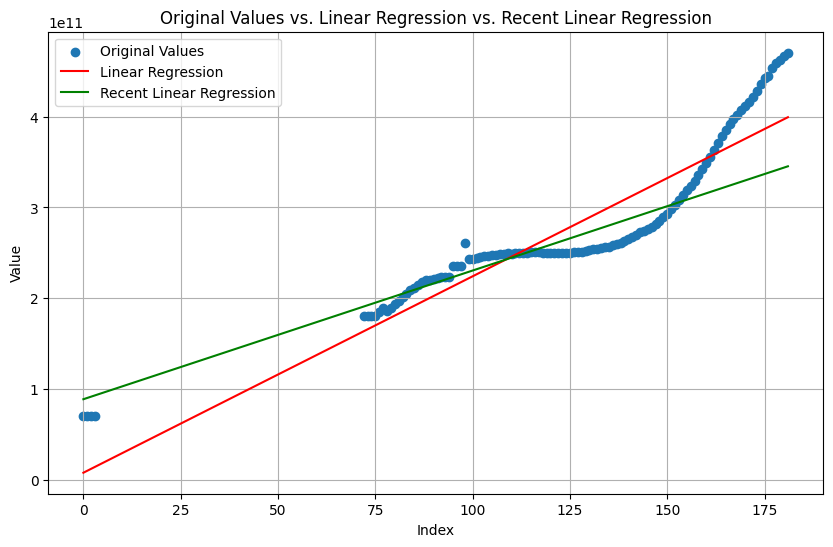

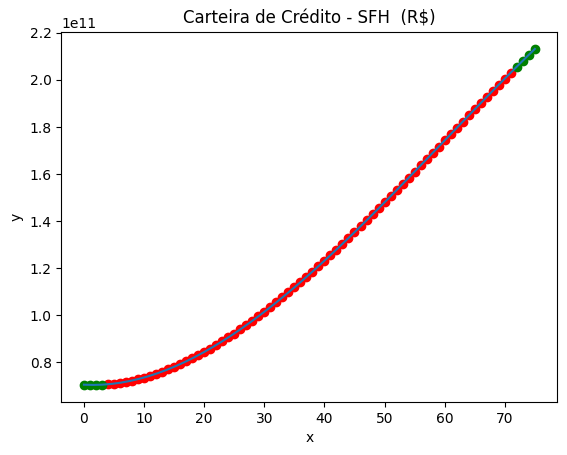

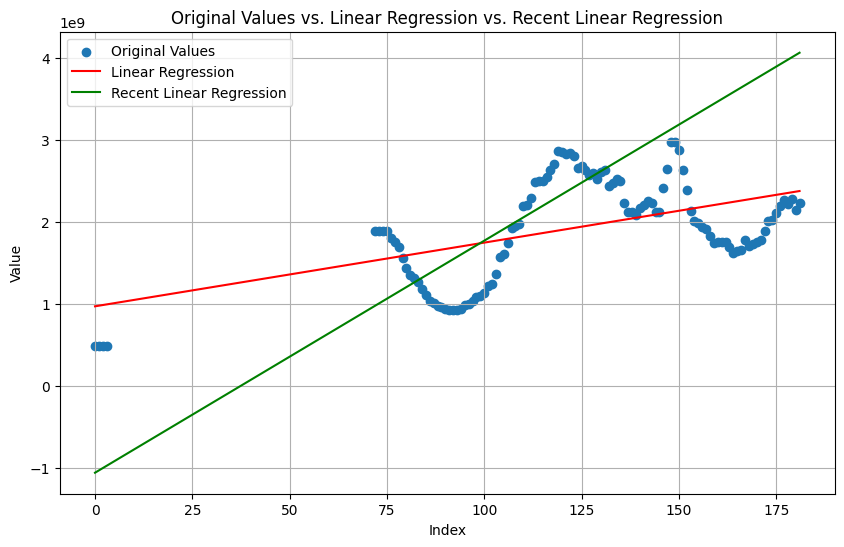

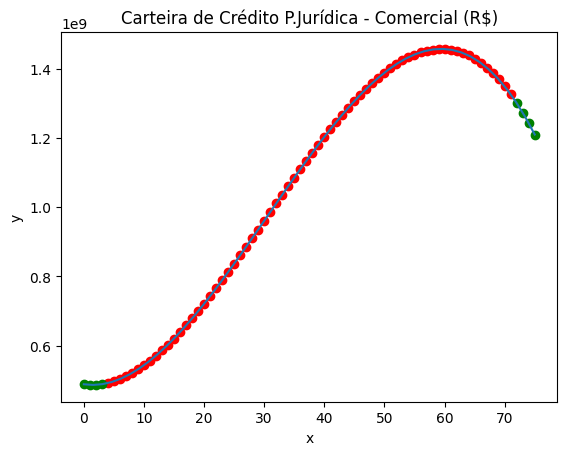

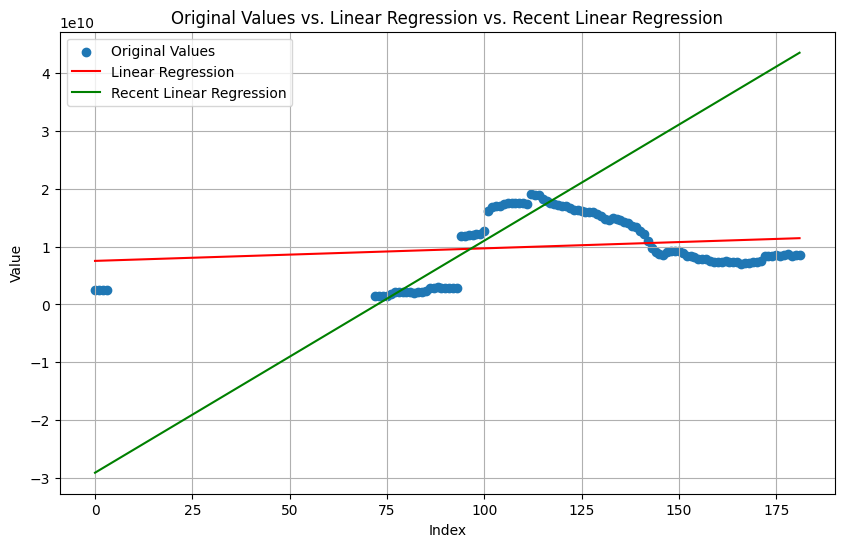

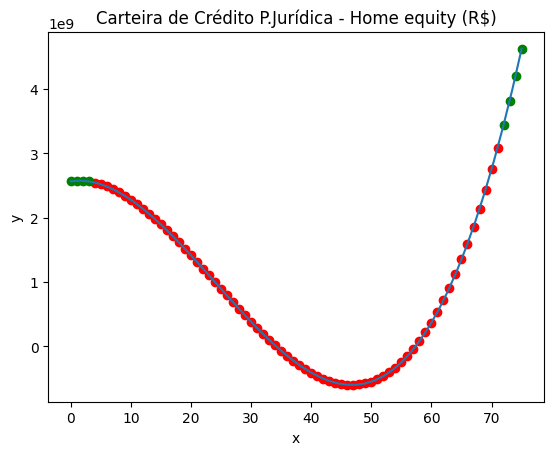

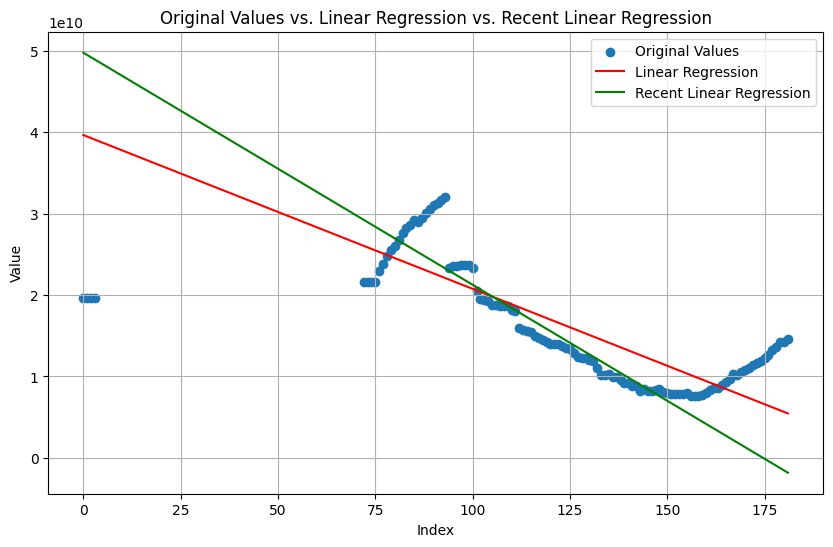

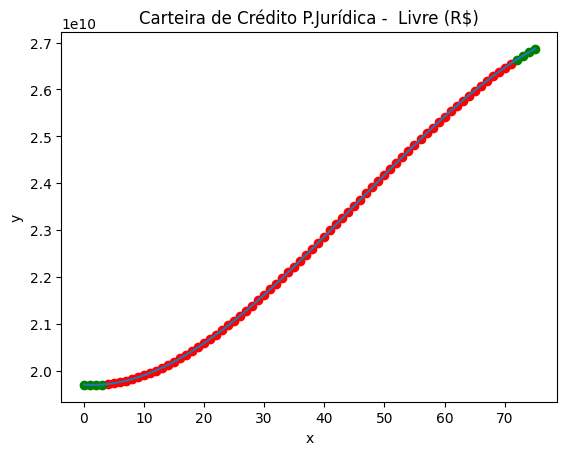

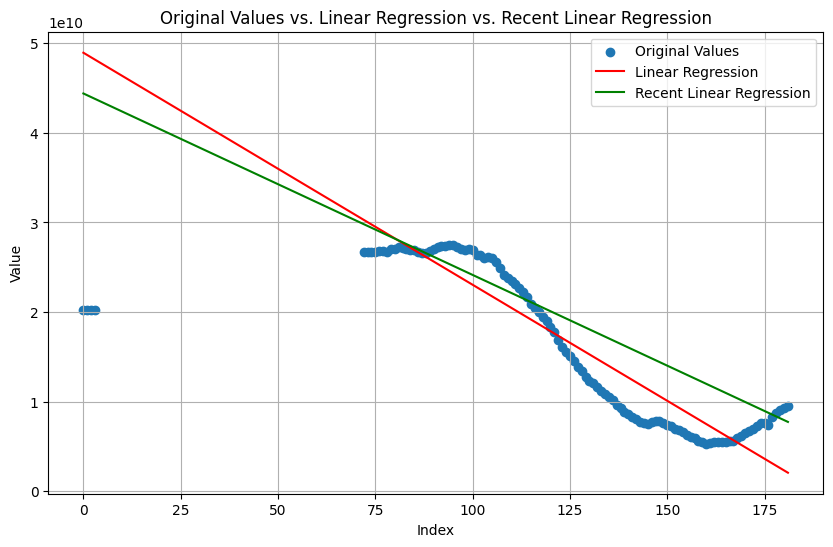

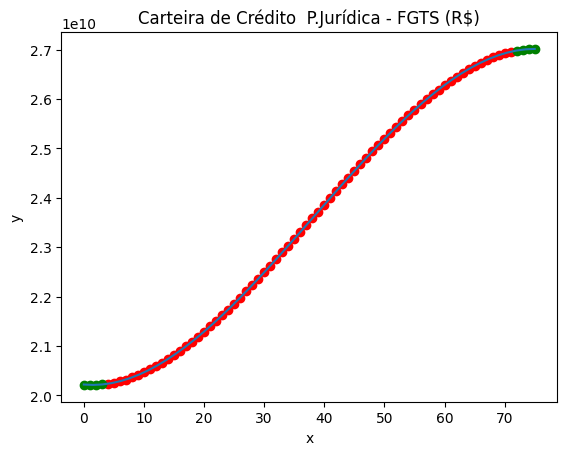

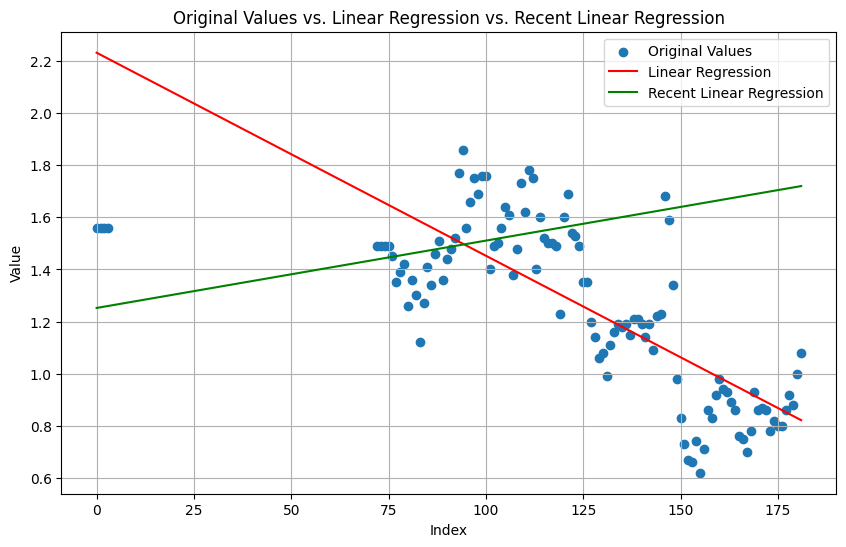

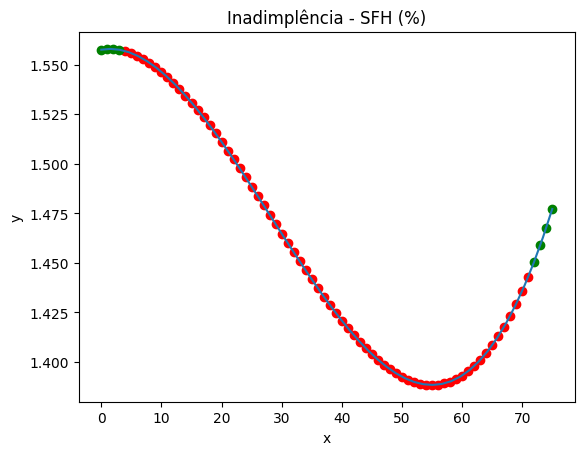

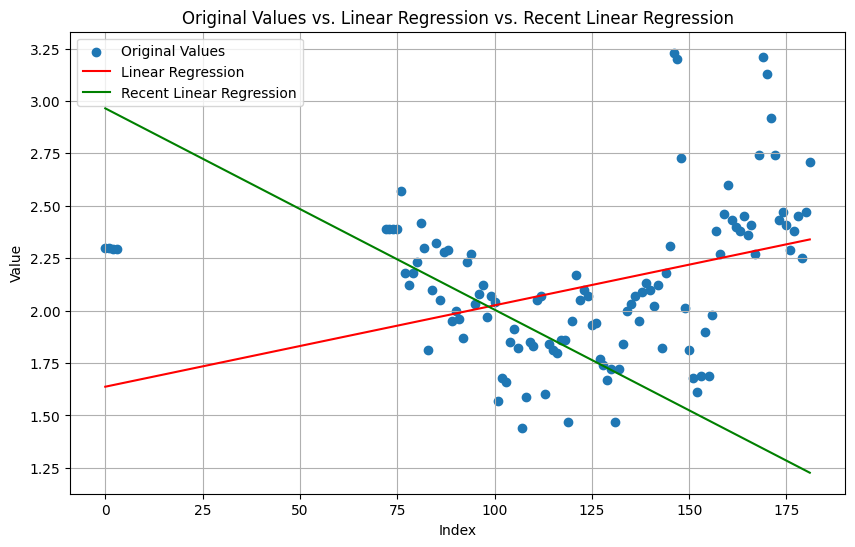

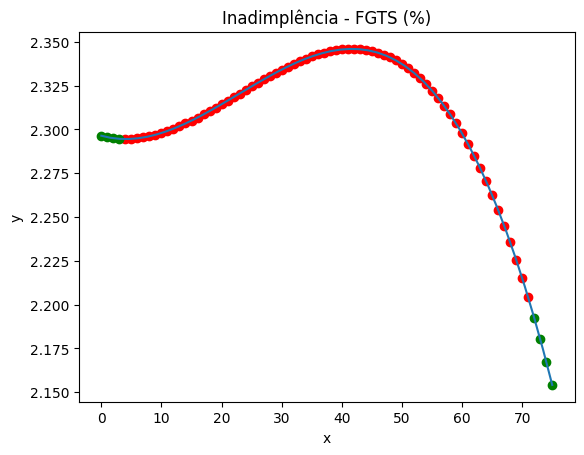

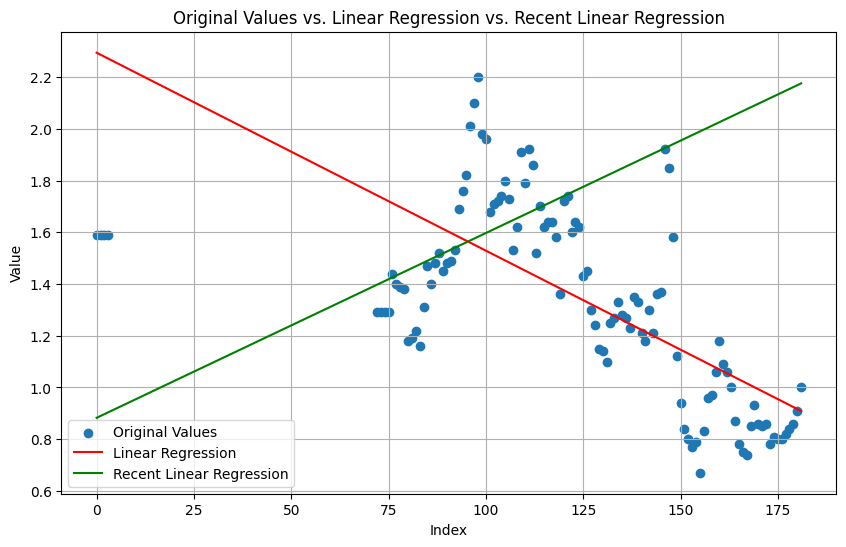

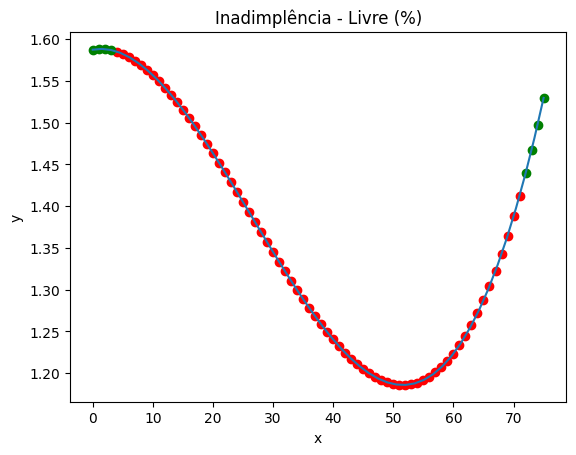

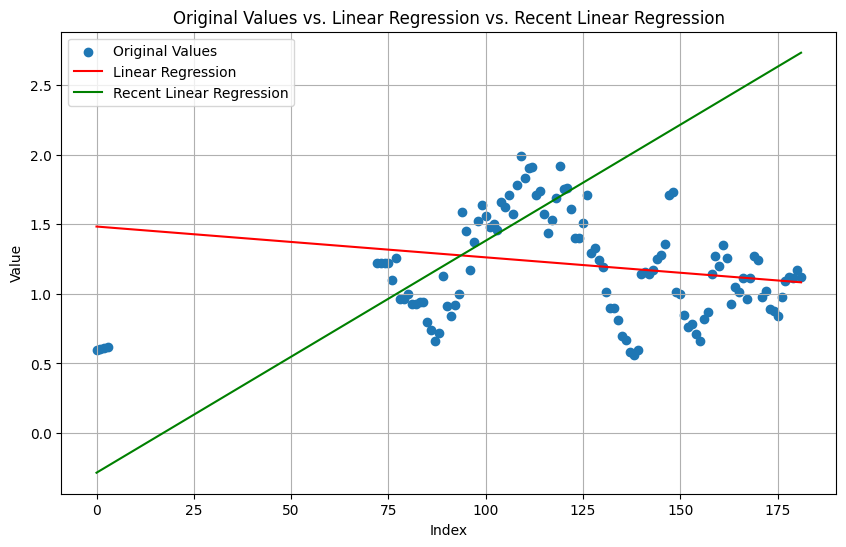

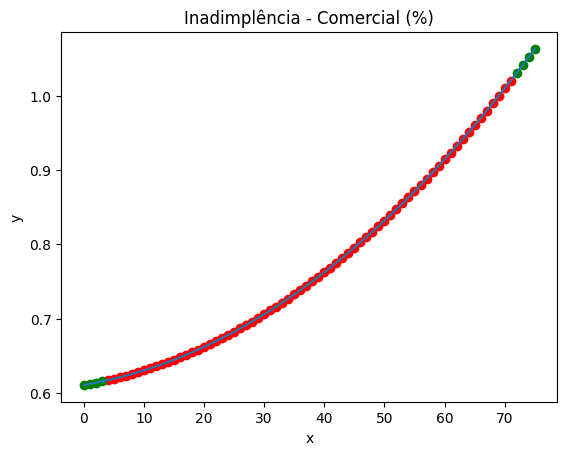

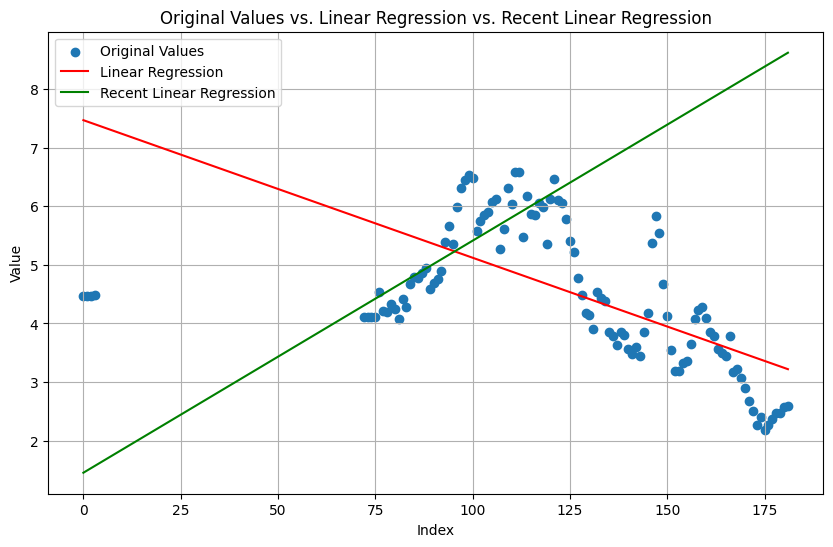

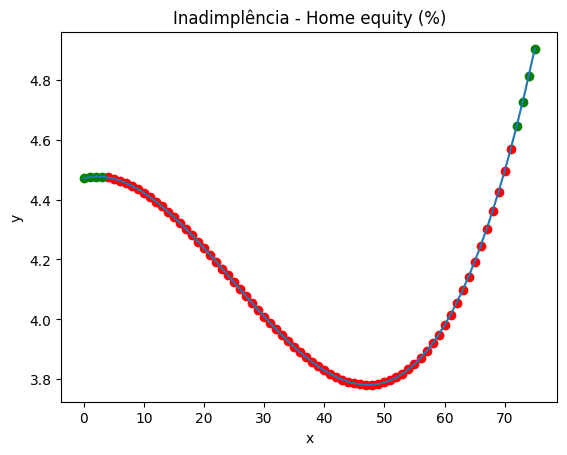

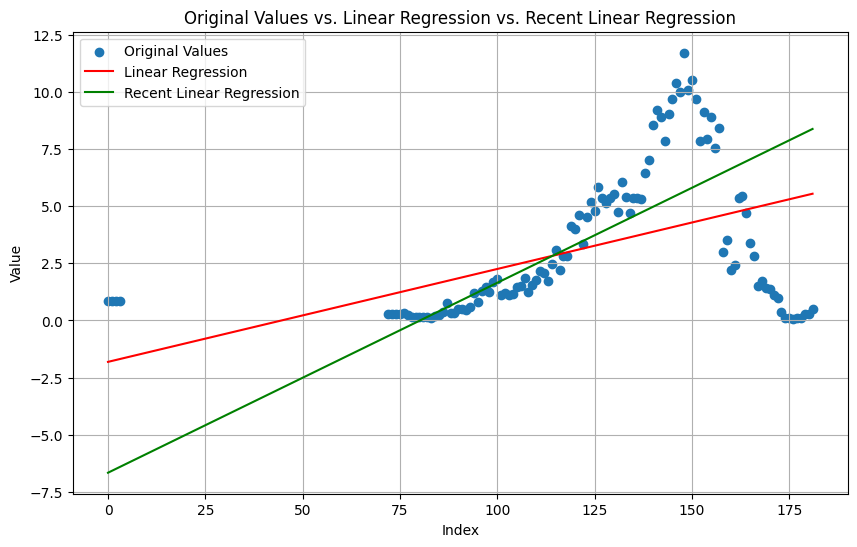

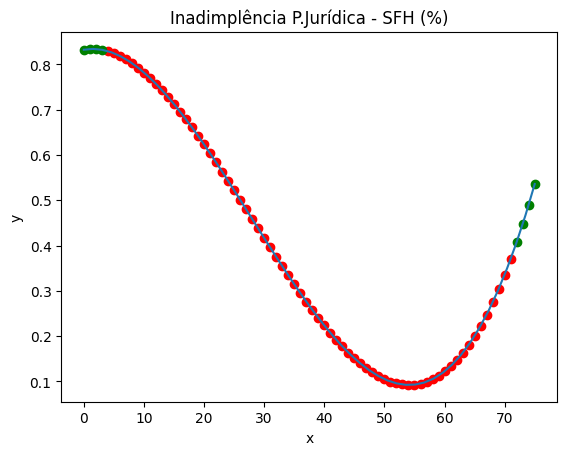

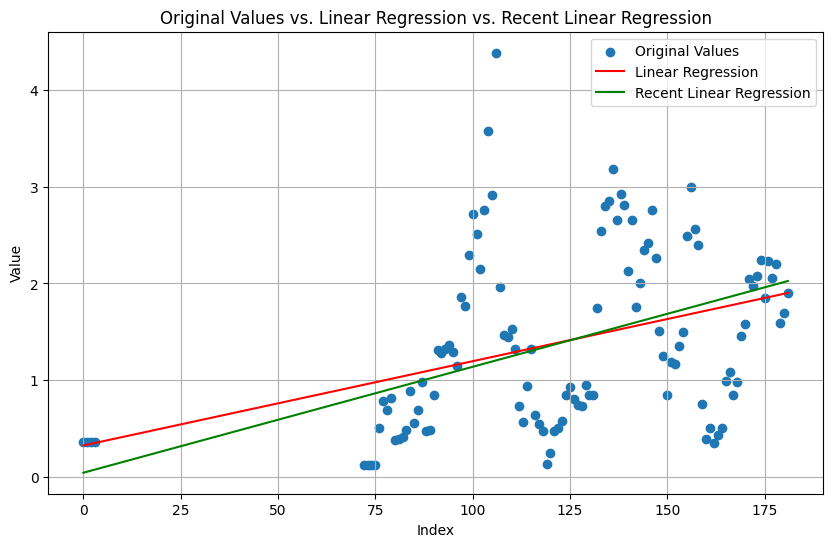

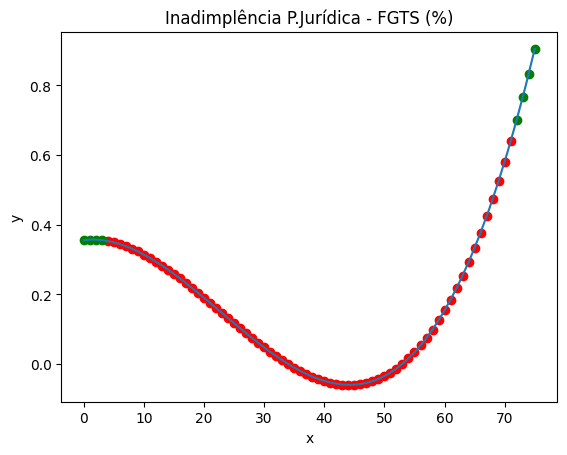

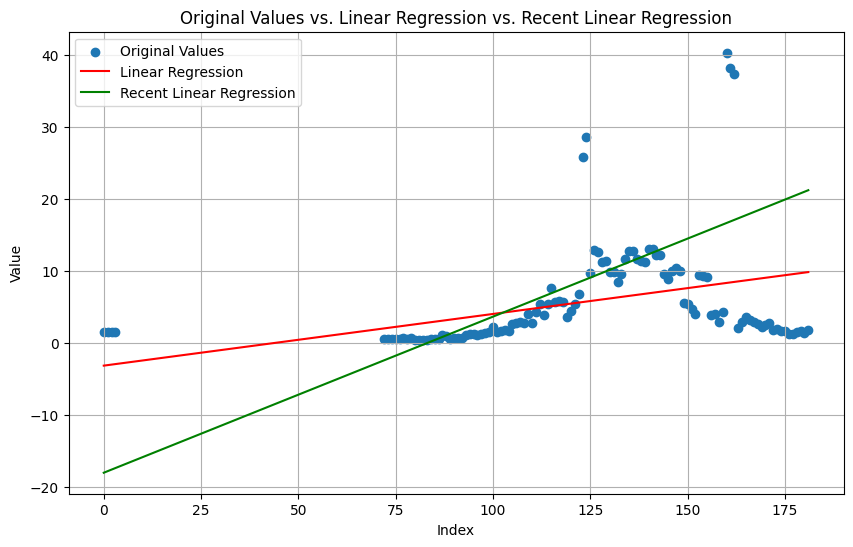

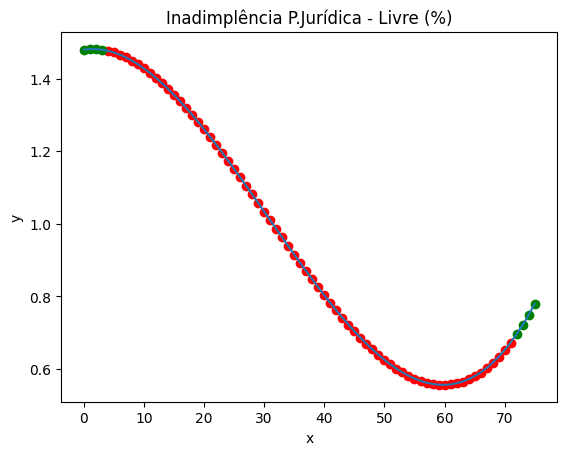

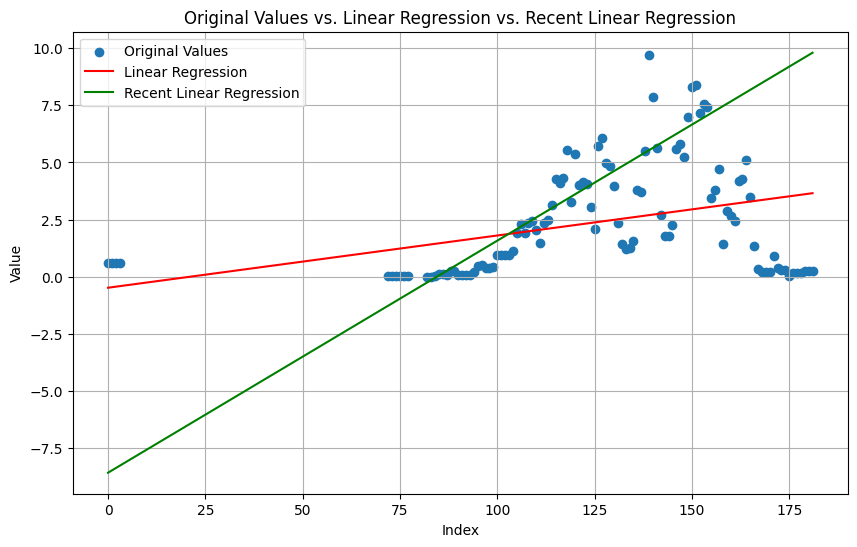

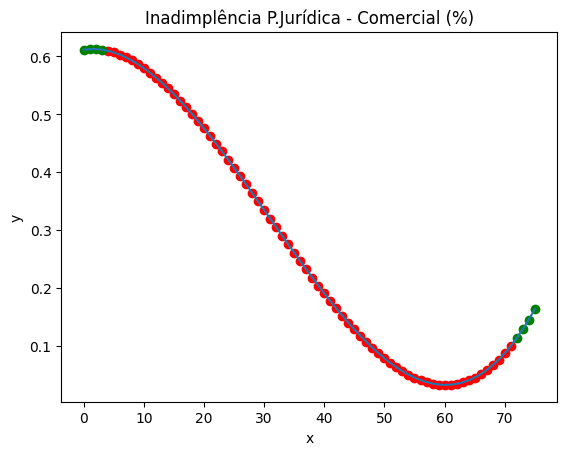

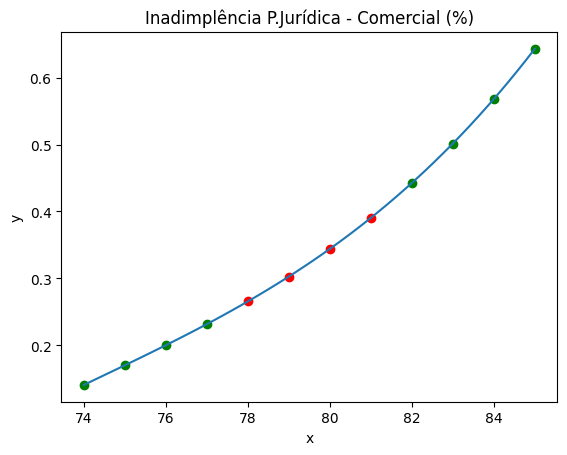

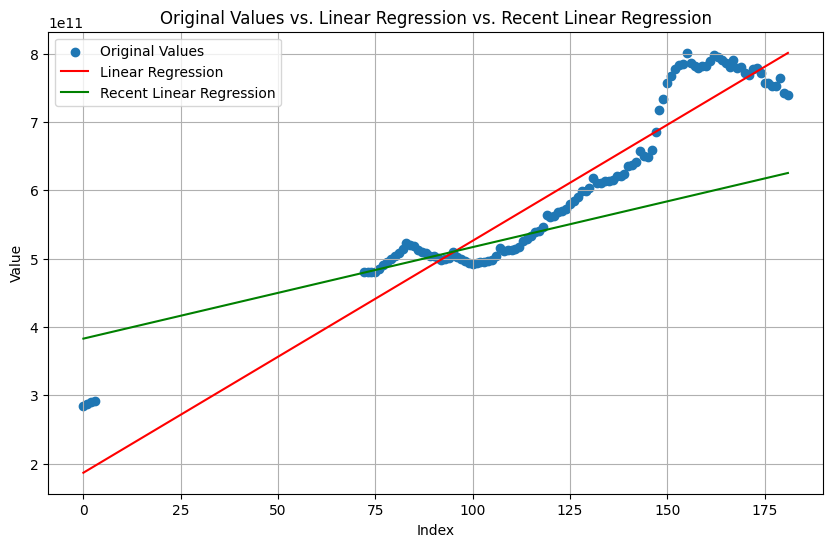

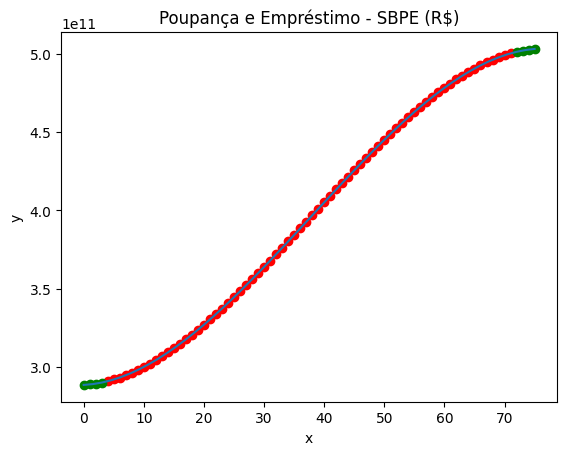

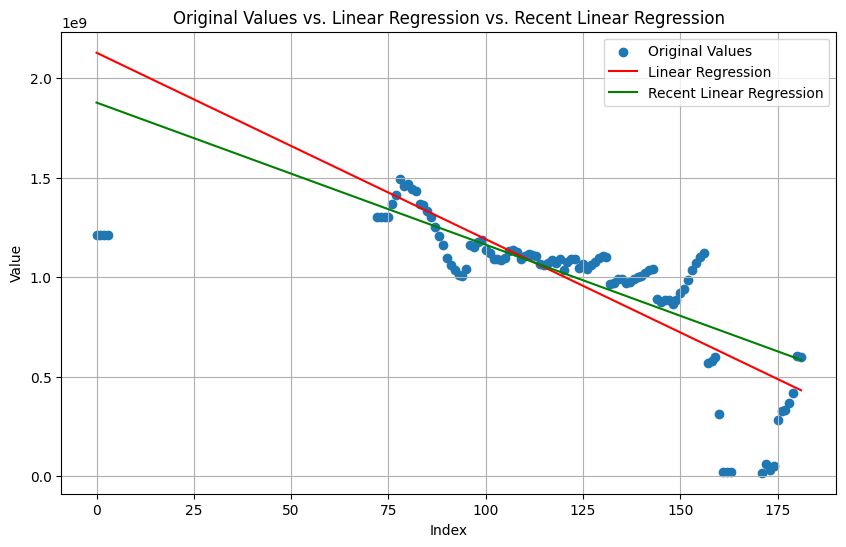

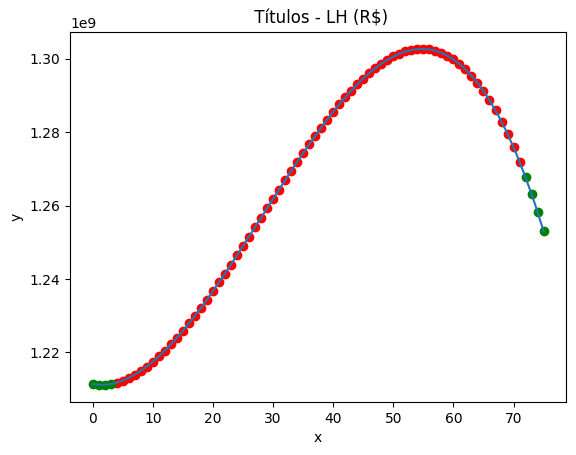

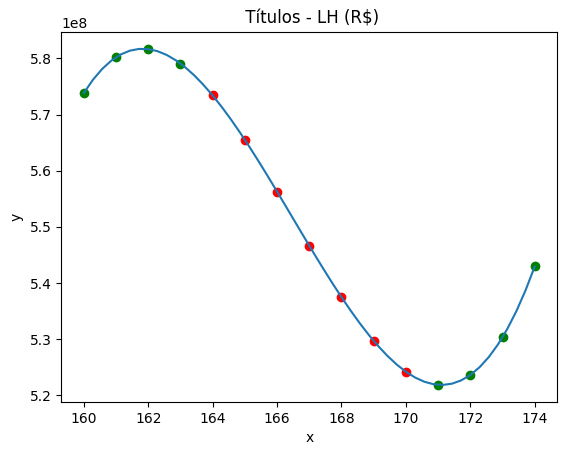

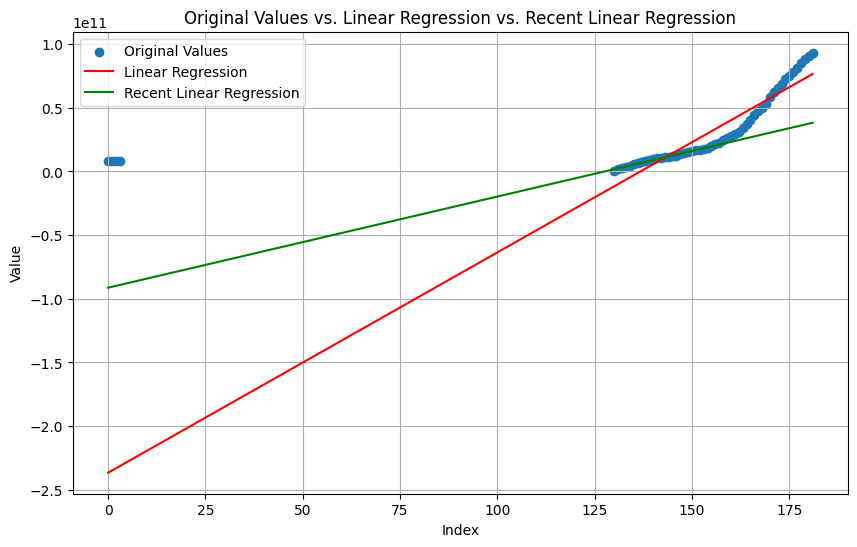

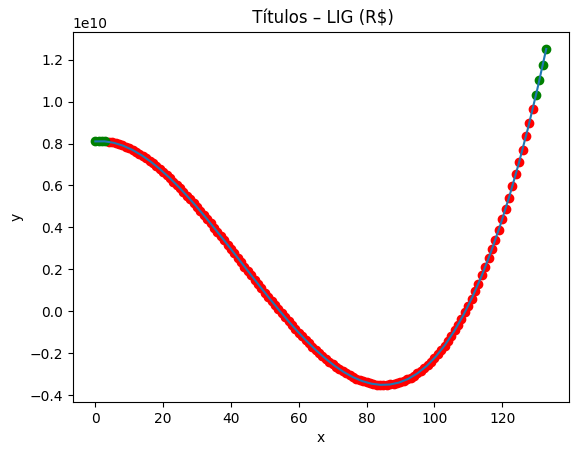

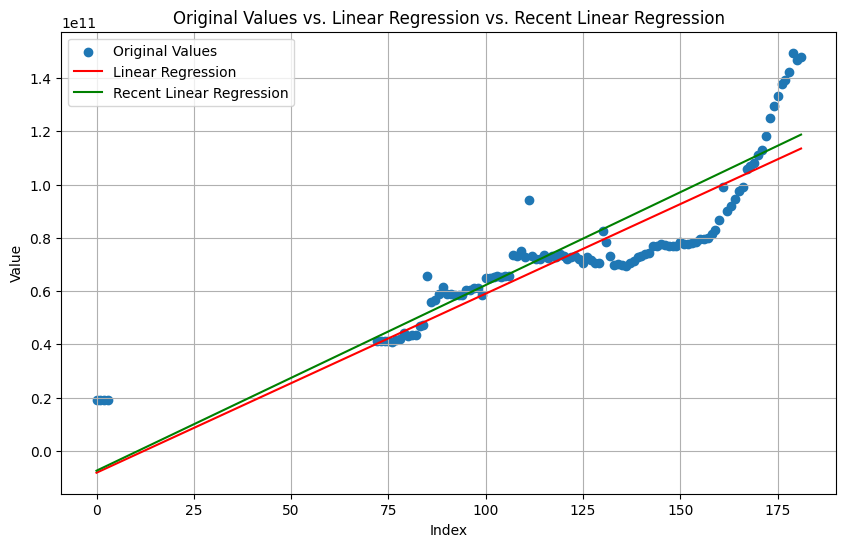

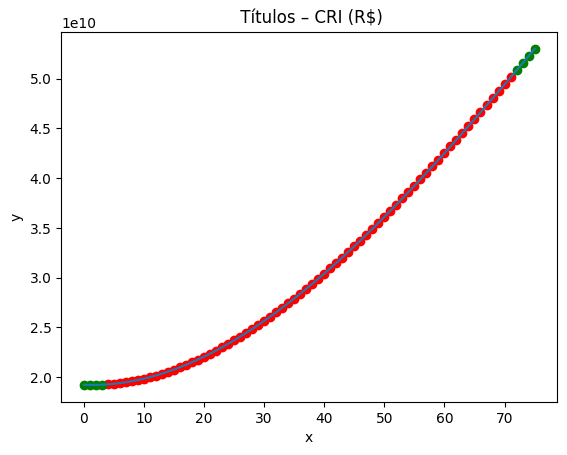

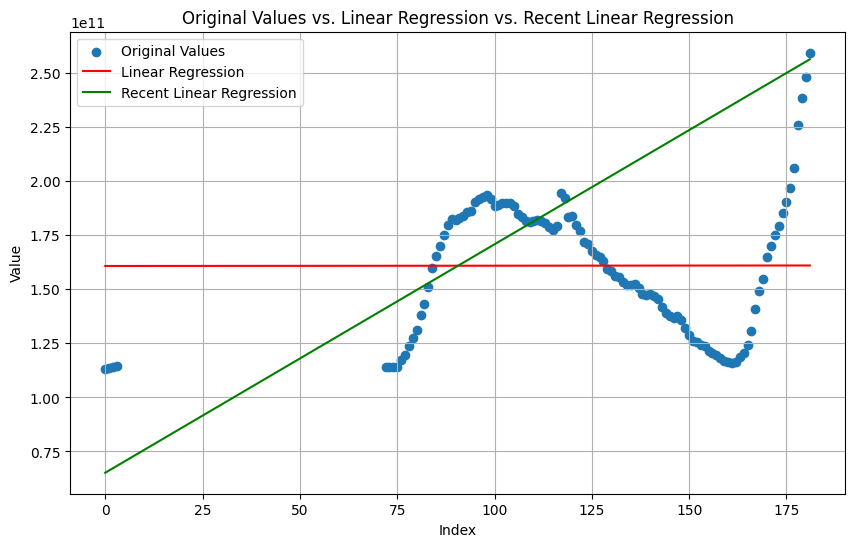

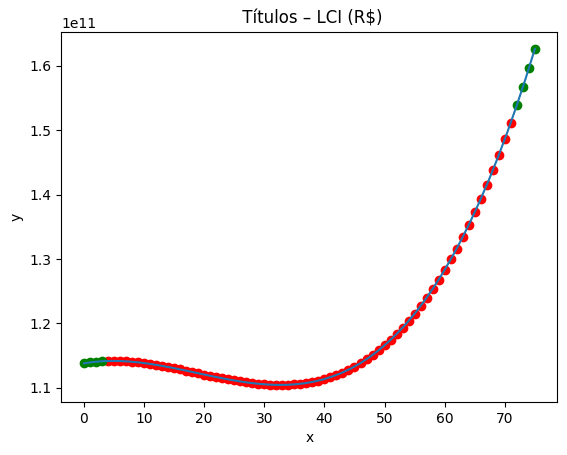

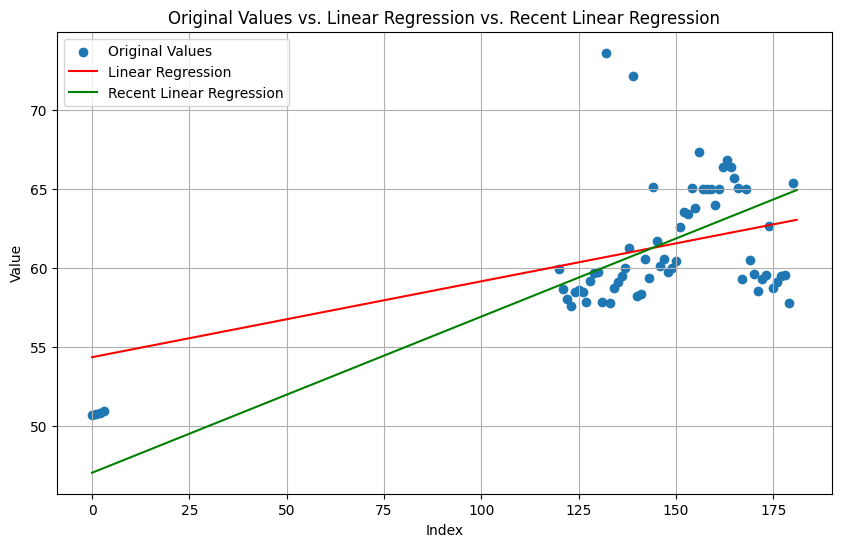

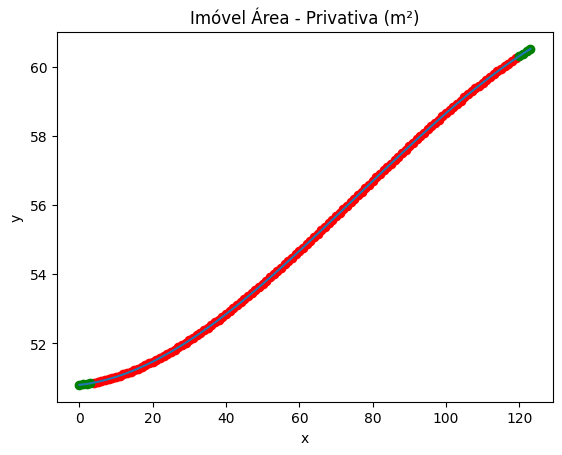

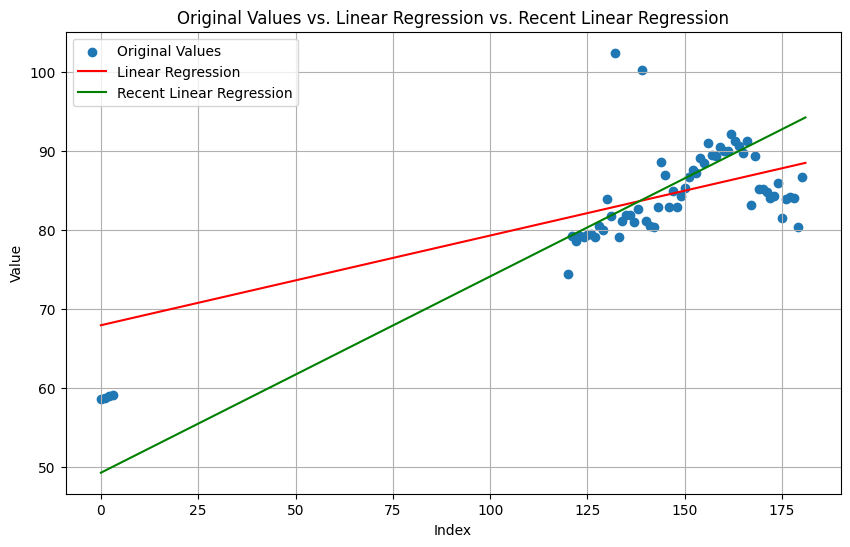

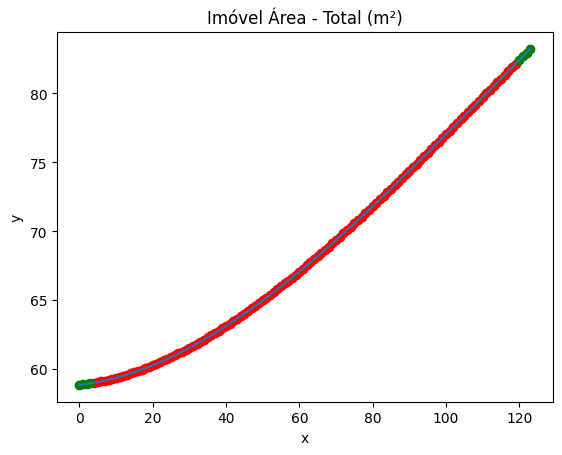

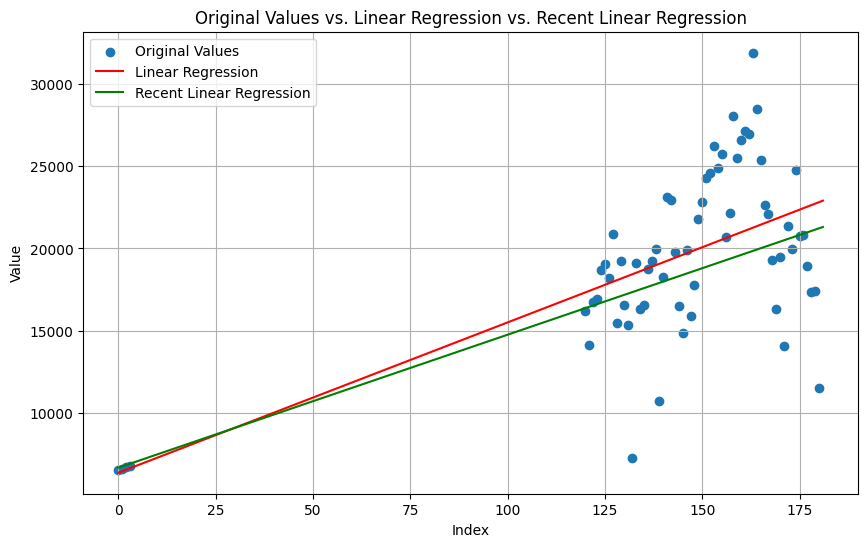

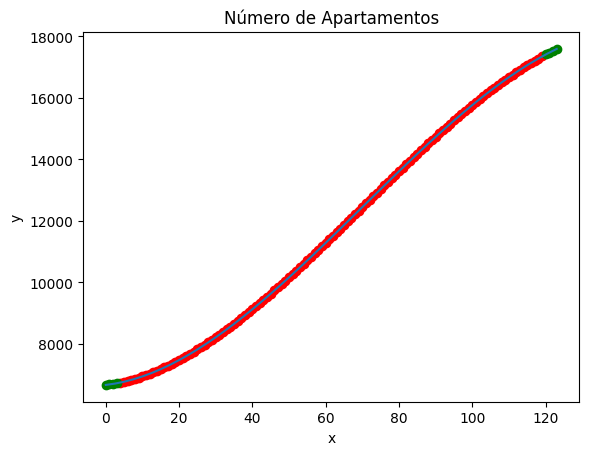

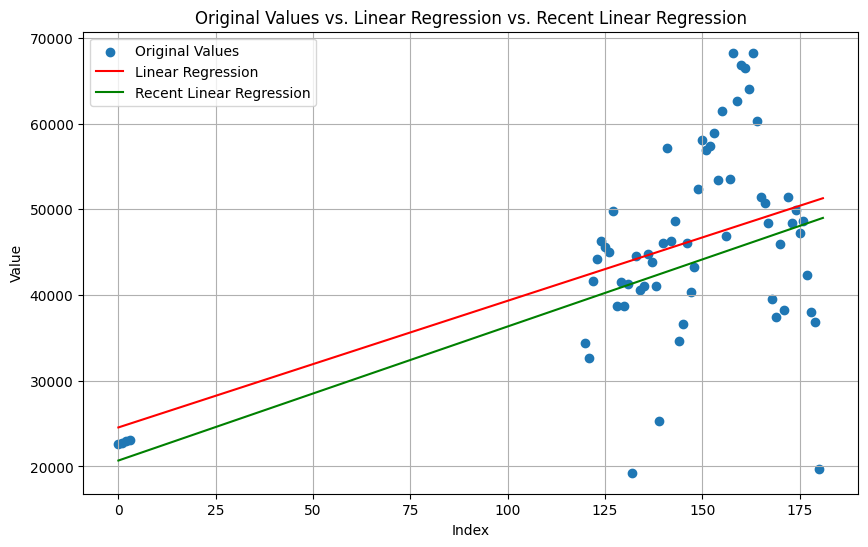

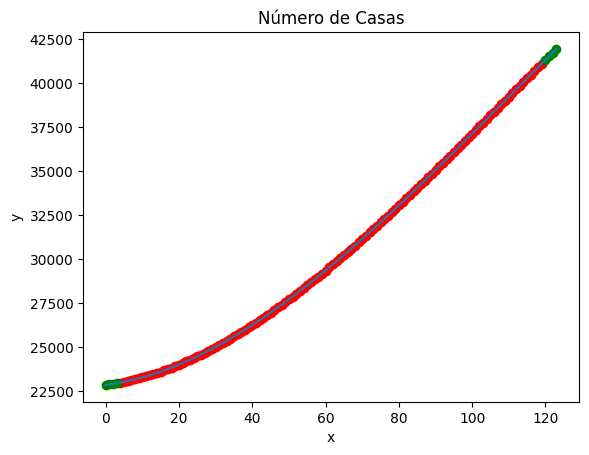

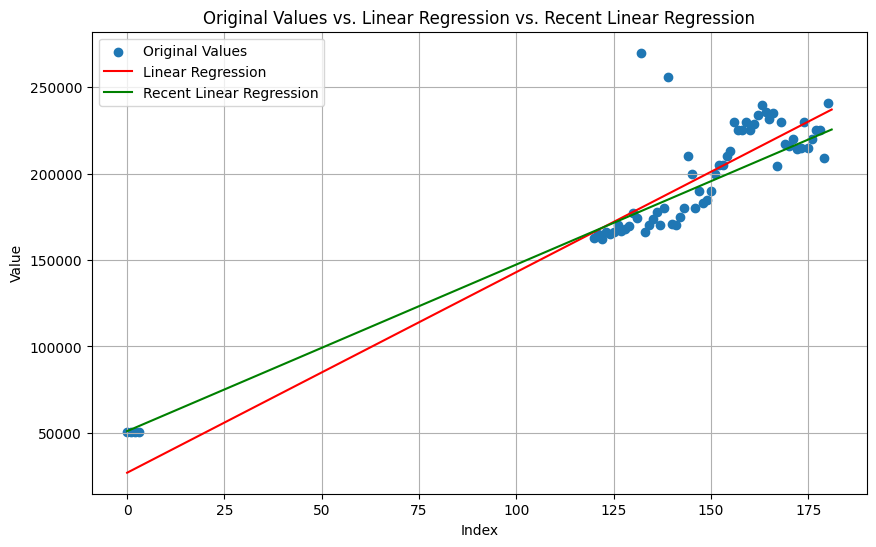

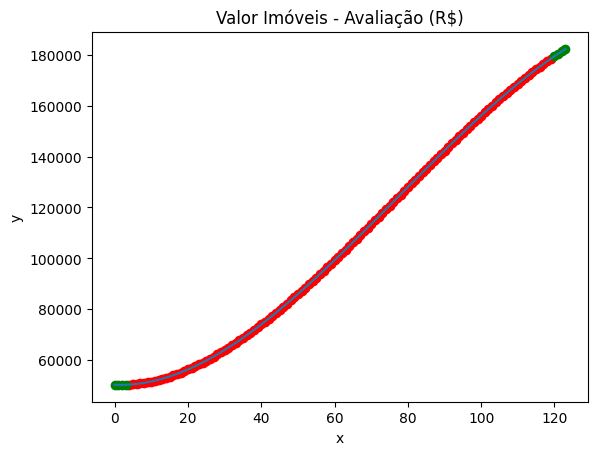

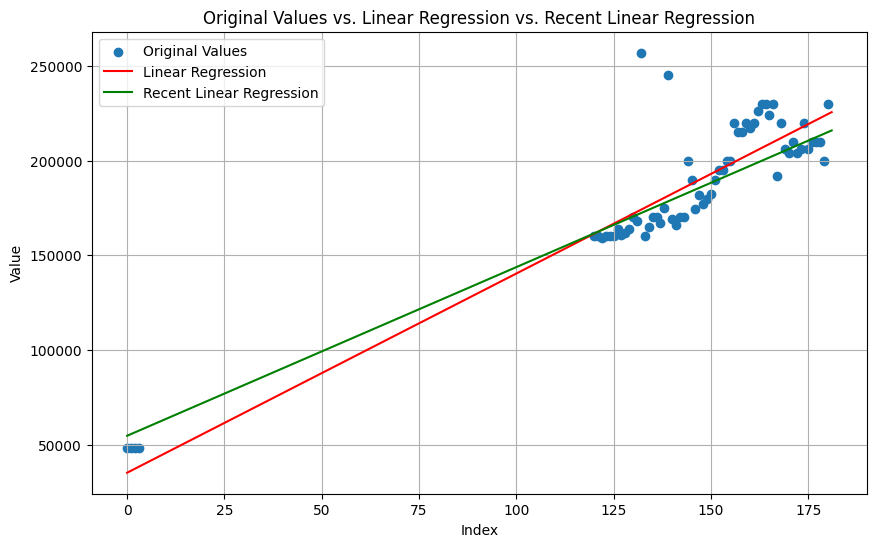

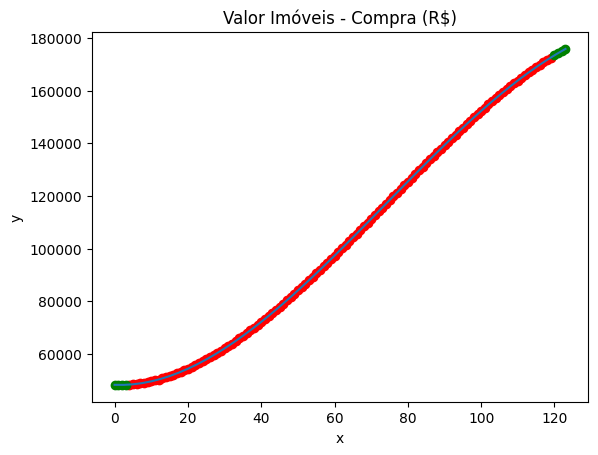

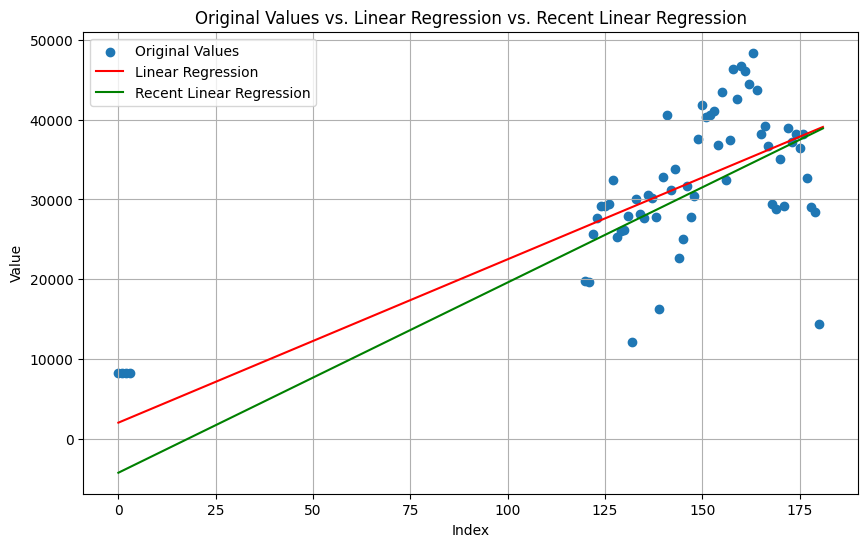

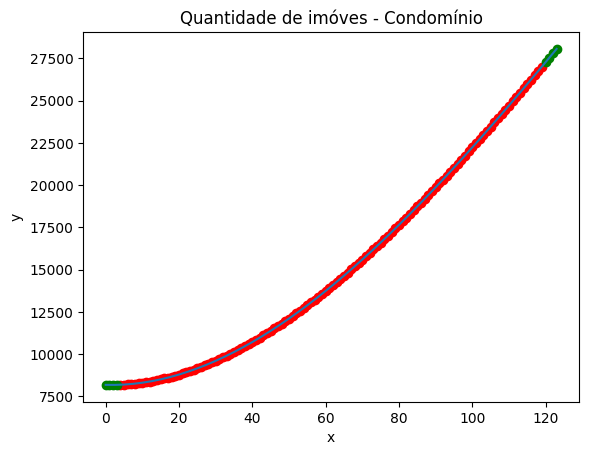

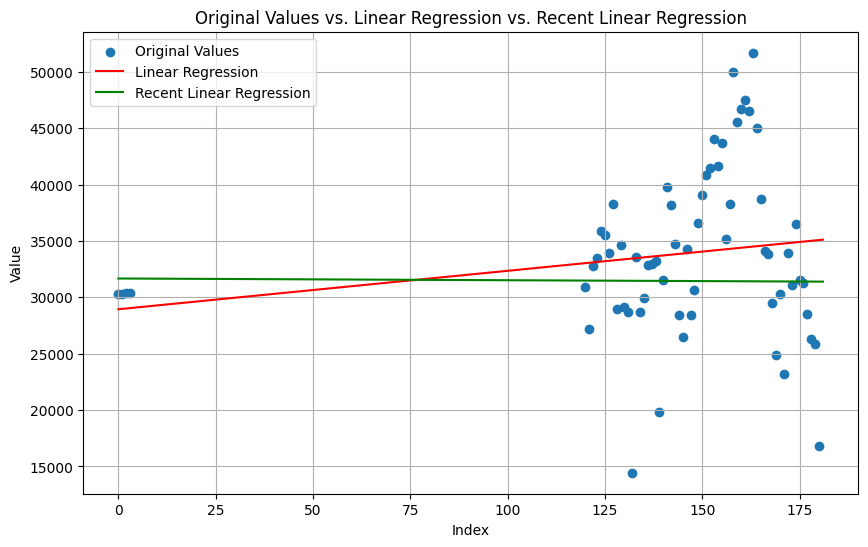

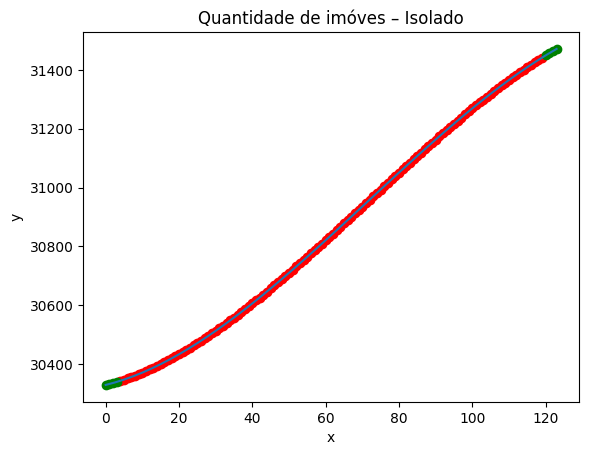

Ano  Contratação Comercial (Bi R$)  \
0    2008-01-31                   4.596283e+07   
1    2008-02-29                   4.593629e+07   
2    2008-03-31                   4.592081e+07   
3    2008-04-30                   4.591915e+07   
4    2008-05-31                   4.586047e+07   
..          ...                            ...   
177  2022-10-31                   5.870882e+07   
178  2022-11-30                   5.861948e+07   
179  2022-12-31                   5.831044e+07   
180  2023-01-31                   5.784881e+07   
181  2023-02-28                   5.713352e+07   

     Contratação  Home equity (Bi R$)  Contratação  Livre (Bi R$)  \
0                        2.106034e+08                1.542506e+09   
1                        2.106606e+08                1.542506e+09   
2                        2.106939e+08                1.542506e+09   
3                        2.106975e+08                1.542506e+09   
4                        2.110463e+08                1.546581e+09   
..                                ...                         ...   
177                      3.726383e+08                1.661154e+09   
178                      3.709264e+08                1.647996e+09   
179                      3.695949e+08                1.632674e+09   
180                      3.692419e+08                1.637145e+09   
181                      3.703388e+08                1.636270e+09   

     Contratação  FGTS (Bi R$)  Contratação  SFH (Bi R$)  \
0                 1.934545e+09              3.276232e+09   
1                 1.940914e+09              3.277221e+09   
2                 1.944630e+09              3.277799e+09   
3                 1.945028e+09              3.277861e+09   
4                 1.951026e+09              3.288639e+09   
..                         ...                       ...   
177               3.936708e+09              8.651128e+09   
178               3.932162e+09              8.627674e+09   
179               3.923414e+09              8.621391e+09   
180               3.848813e+09              8.666693e+09   
181               3.852666e+09              8.691343e+09   

     Contratação Jurídico Comercial (Bi R$)  \
0                              1.486875e+08   
1                              1.486875e+08   
2                              1.486875e+08   
3                              1.486875e+08   
4                              1.494045e+08   
..                                      ...   
177                            1.782098e+08   
178                            1.833944e+08   
179                            1.869965e+08   
180                            1.767381e+08   
181                            1.756464e+08   

     Contratação Jurídico FGTS (Bi R$)  Contratação Jurídico Livre (Bi R$)  \
0                         5.214374e+07                        4.235269e+08   
1                         5.214374e+07                        4.235269e+08   
2                         5.214374e+07                        4.235269e+08   
3                         5.214374e+07                        4.235269e+08   
4                         5.188697e+07                        4.247072e+08   
..                                 ...                                 ...   
177                       2.852302e+08                        5.918791e+08   
178                       2.827300e+08                        5.785948e+08   
179                       2.771986e+08                        5.633801e+08   
180                       2.722025e+08                        5.322804e+08   
181                       2.739398e+08                        5.442921e+08   

     Contratação Jurídico SFH (Bi R$)  ...   Títulos – CRI (R$)  \
0                        5.871672e+08  ...         1.921789e+10   
1                        5.871672e+08  ...         1.921789e+10   
2                        5.871672e+08  ...         1.921789e+10   
3                        5.871672e+08  ...         1.921789e+10   
4                       

In [96]:
df_interpolated = read_csv_replace_missing_by_polynomial('dados_imobilidarios_bcb_extrapolados_2008.csv', 0, 0)
df_interpolated

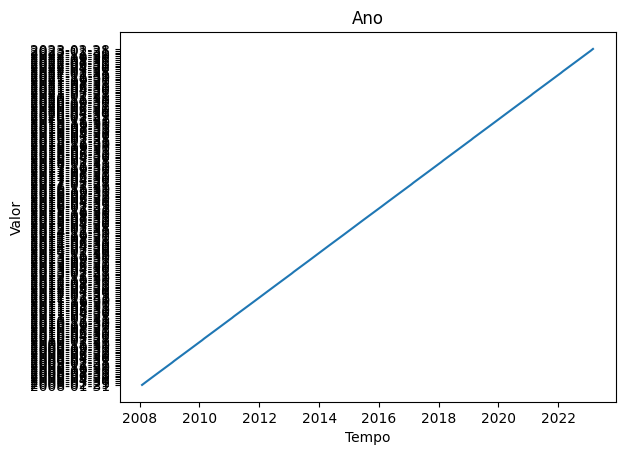

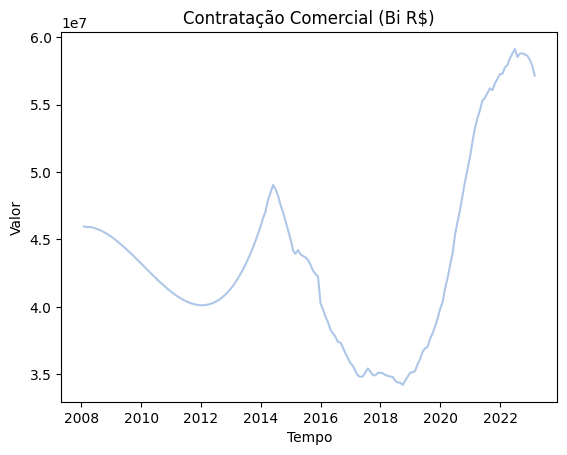

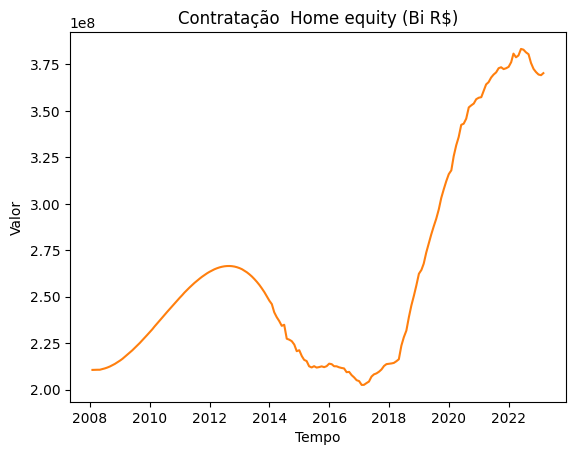

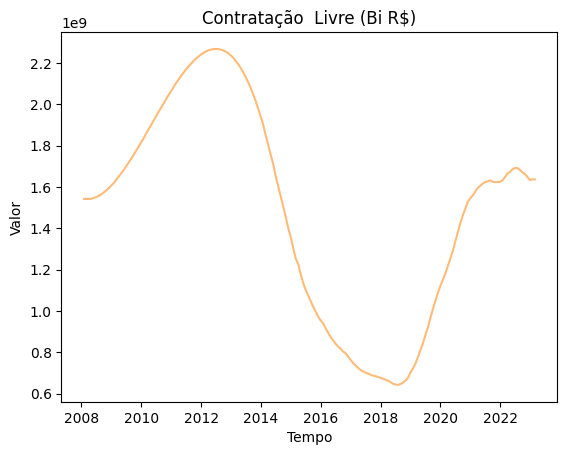

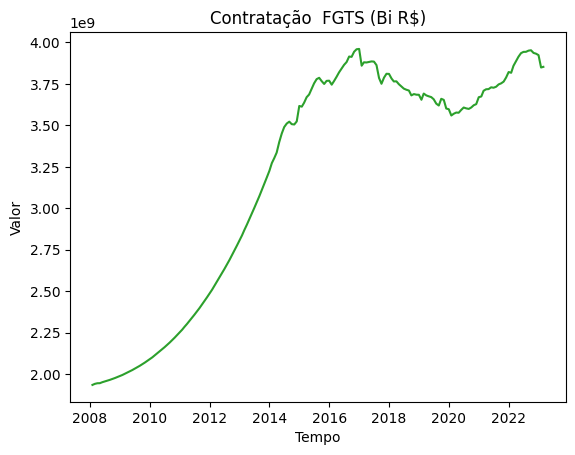

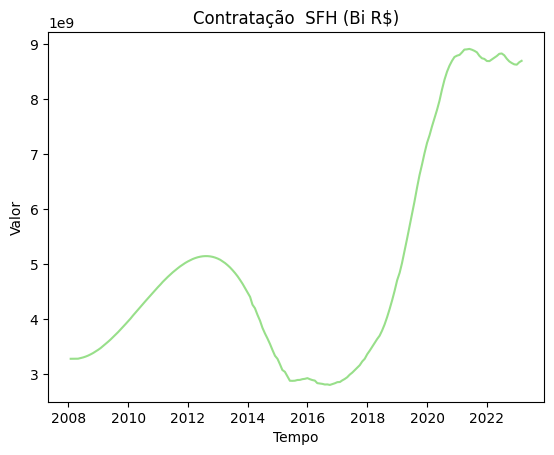

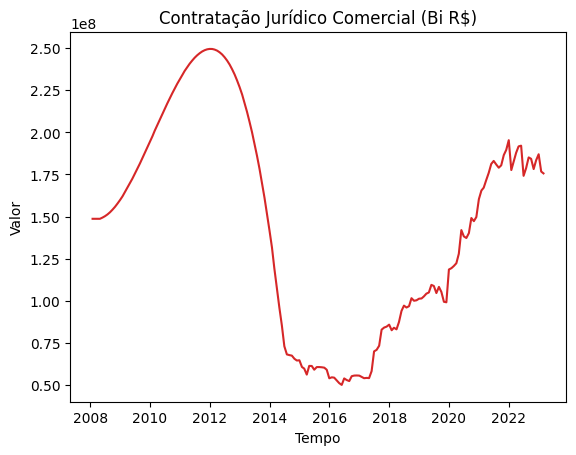

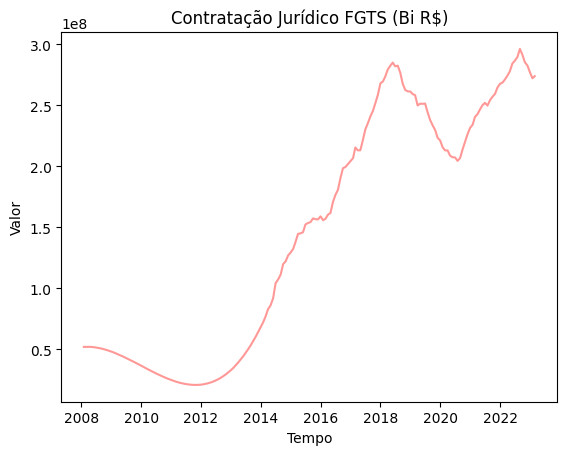

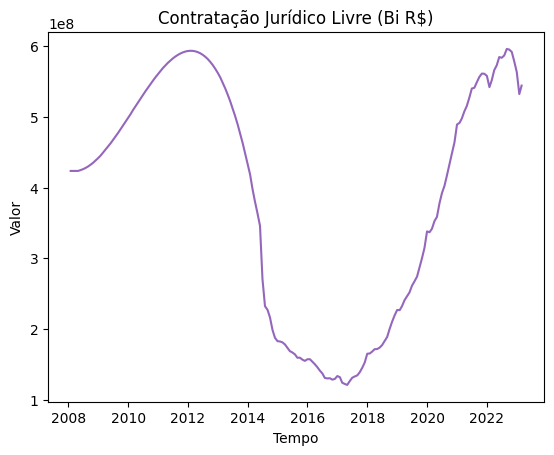

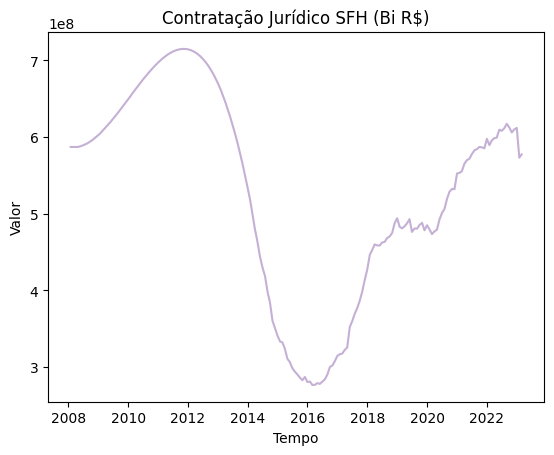

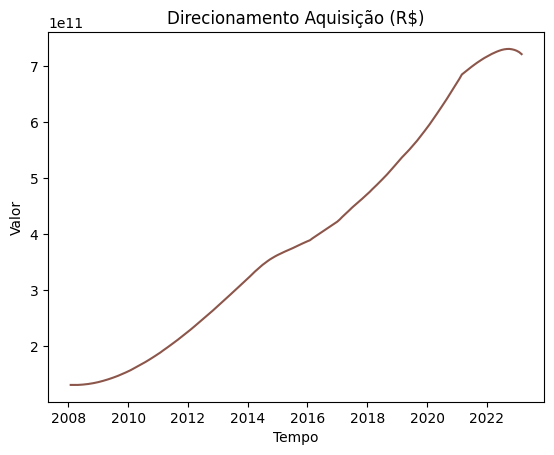

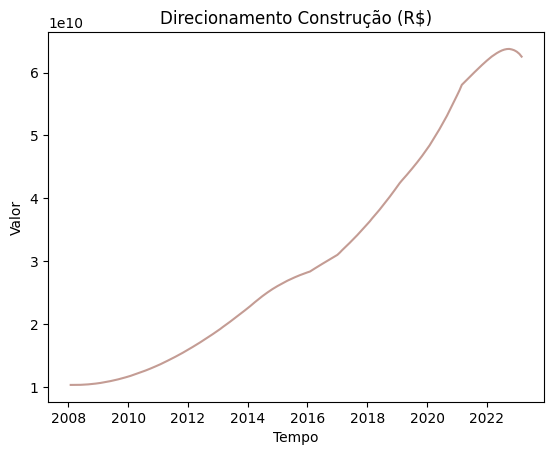

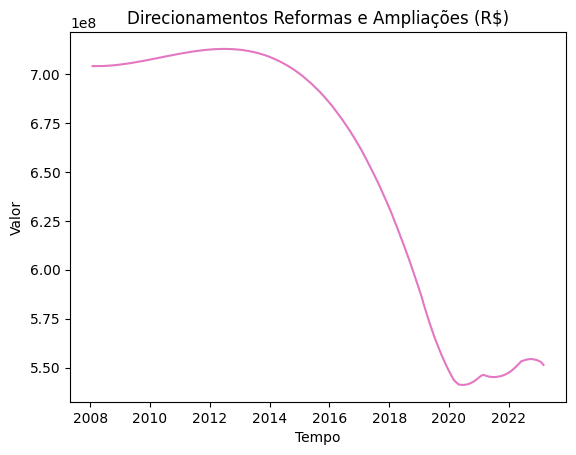

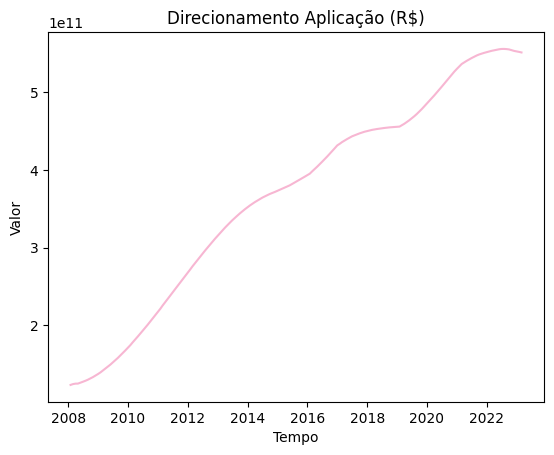

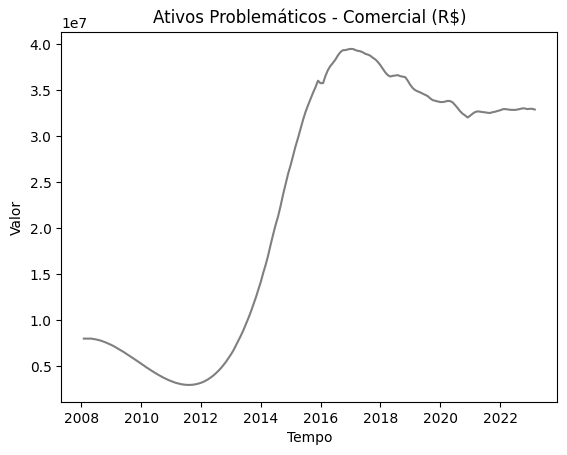

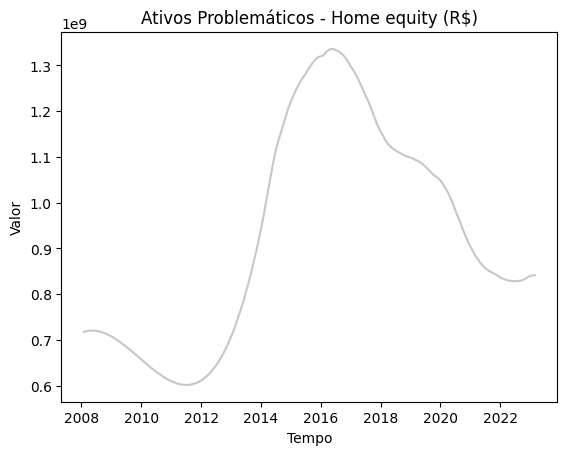

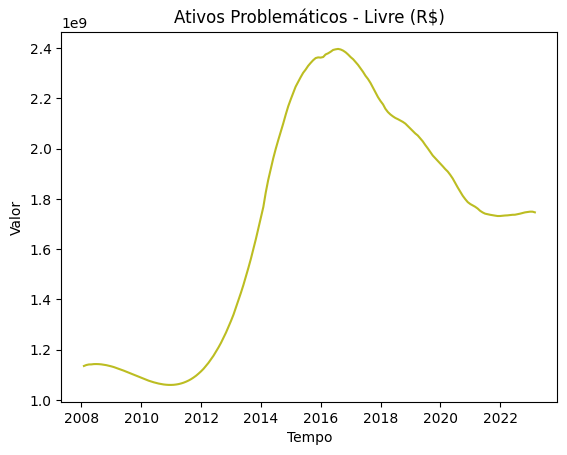

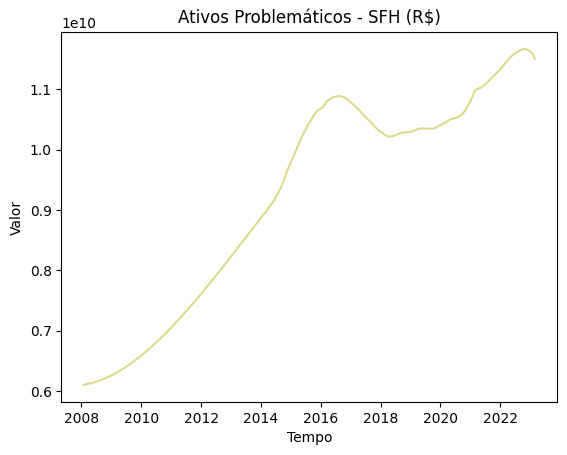

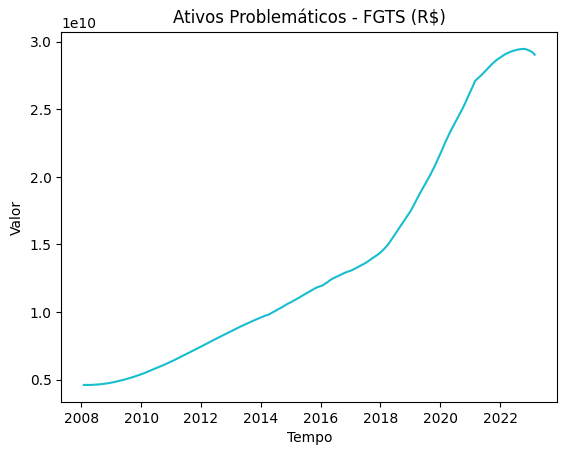

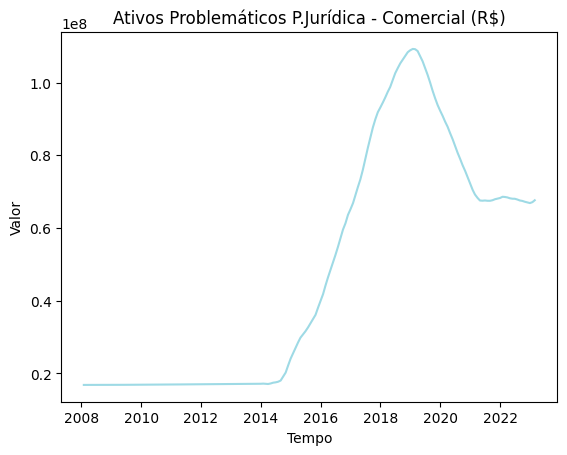

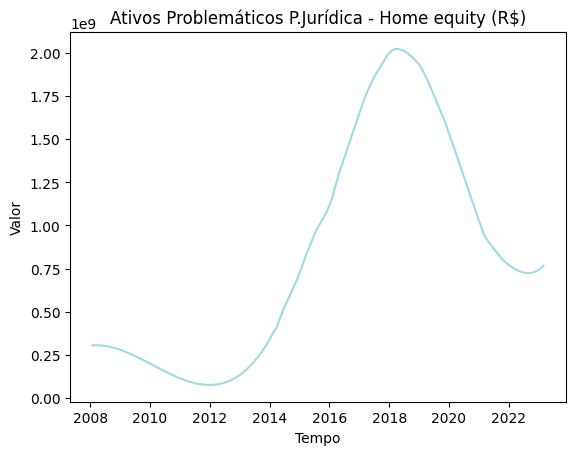

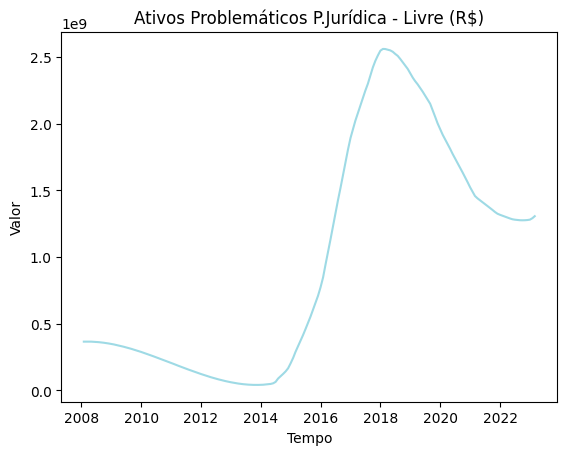

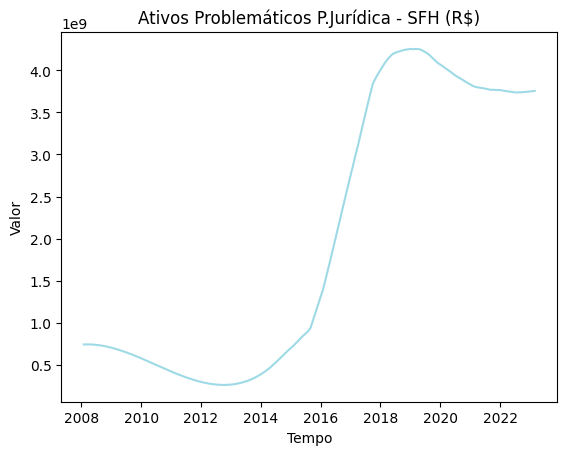

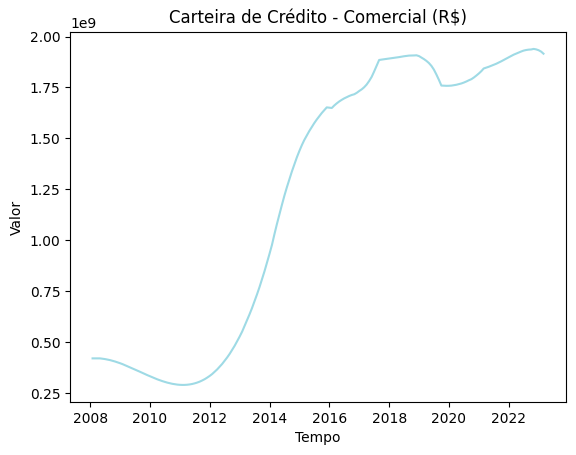

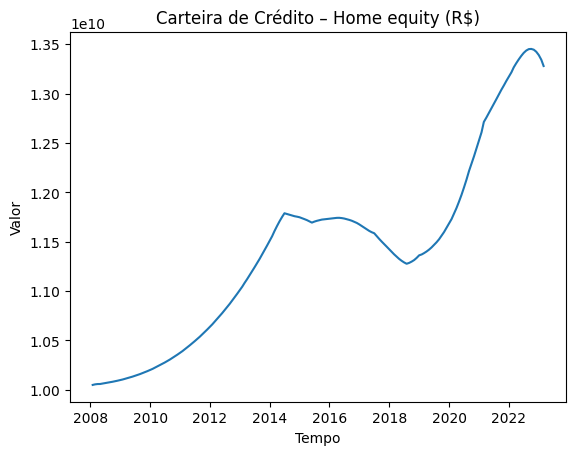

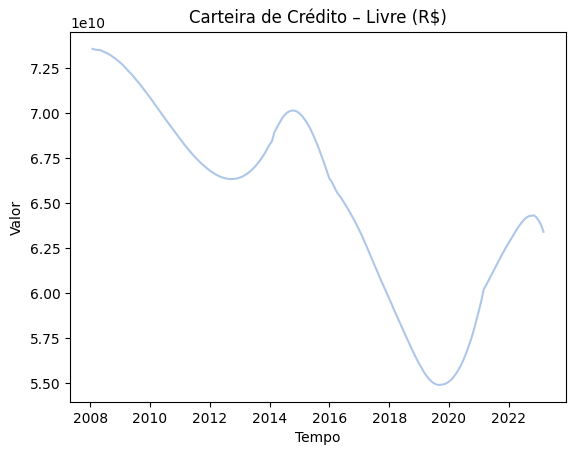

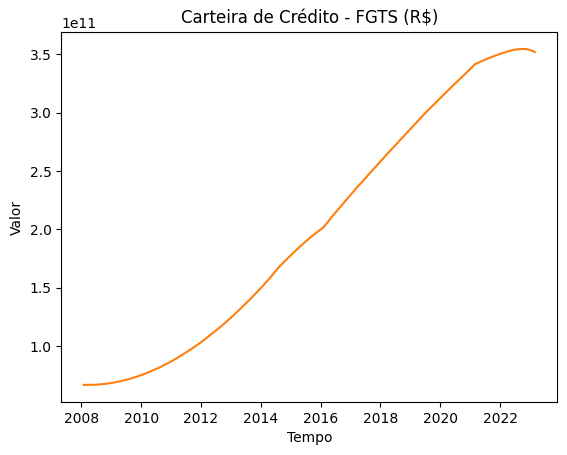

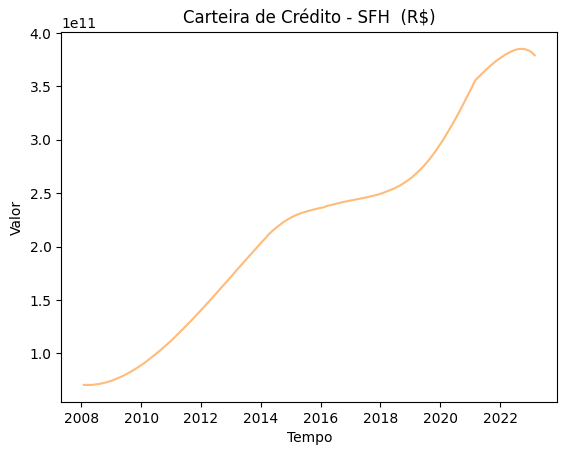

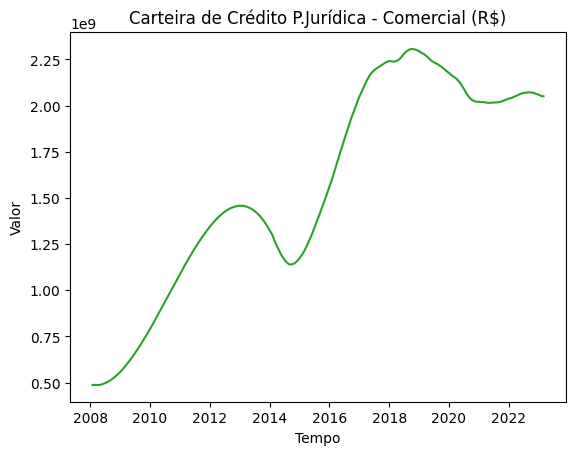

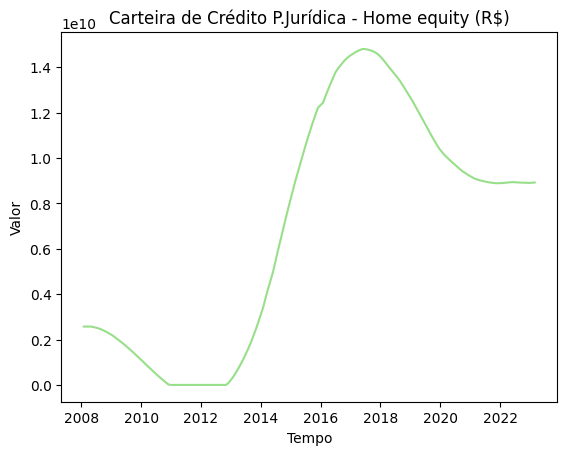

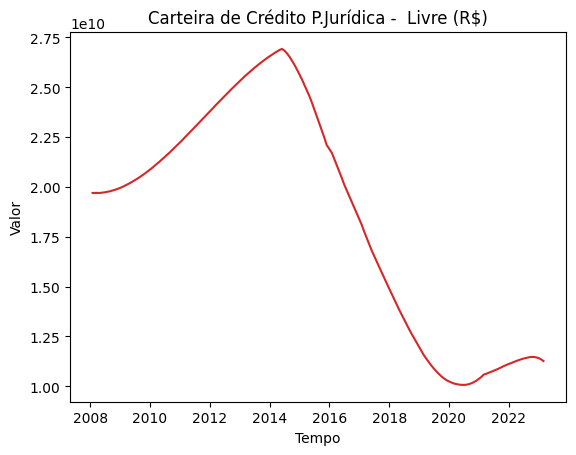

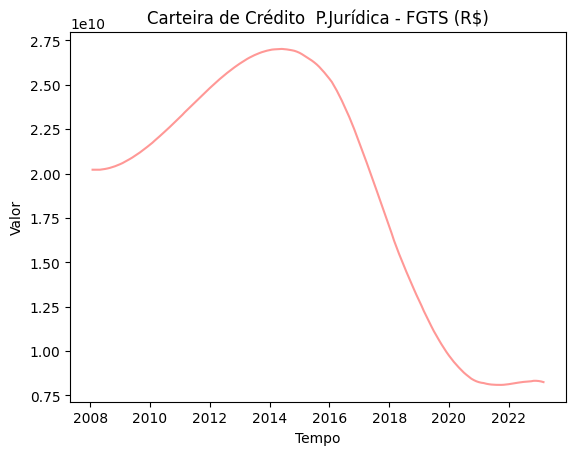

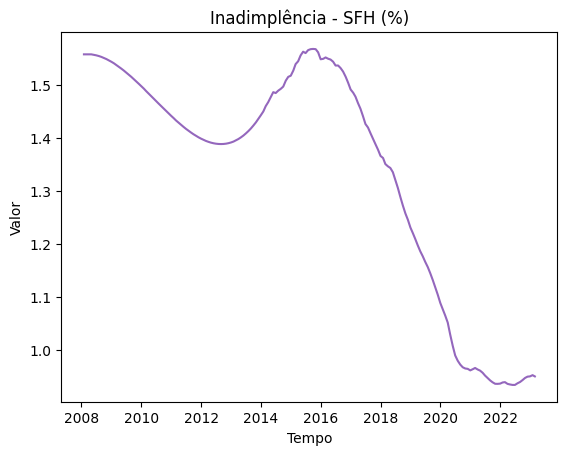

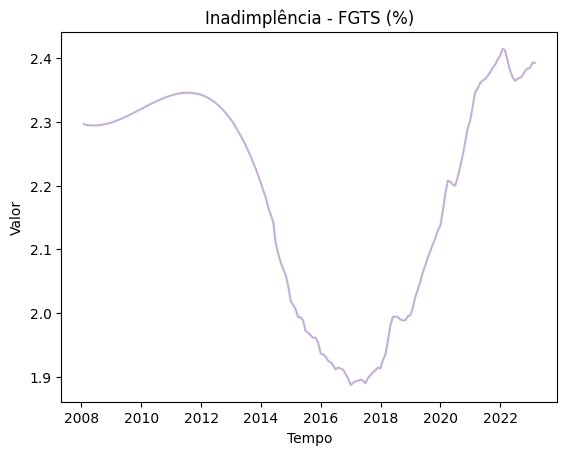

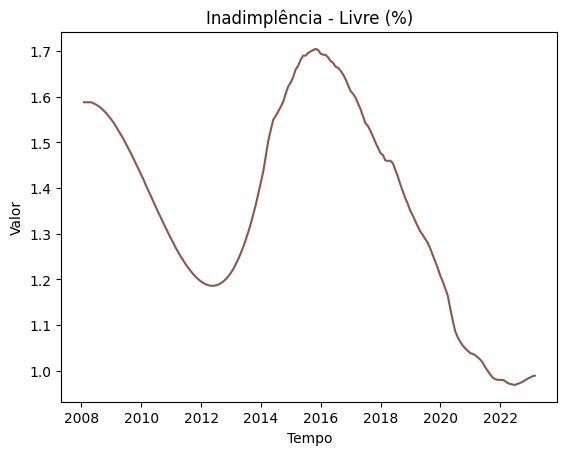

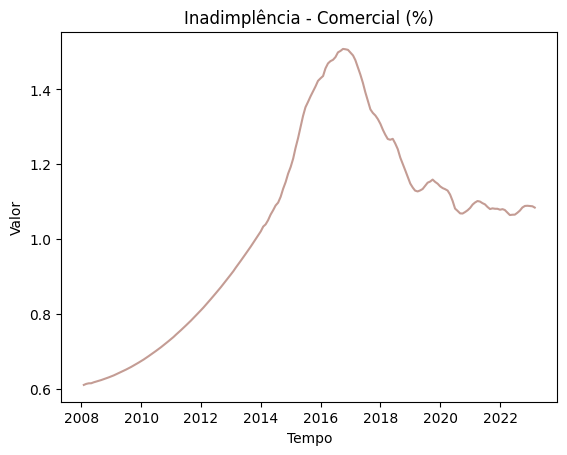

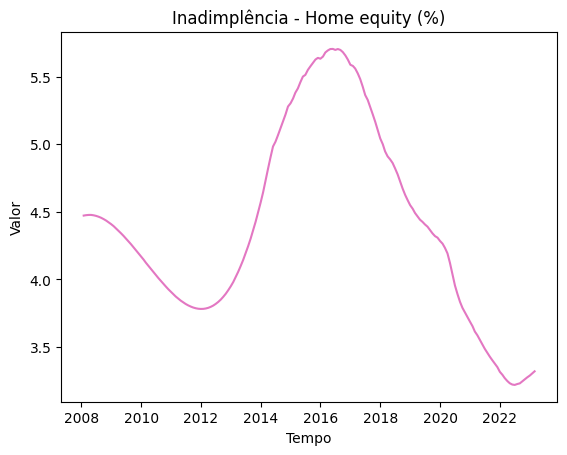

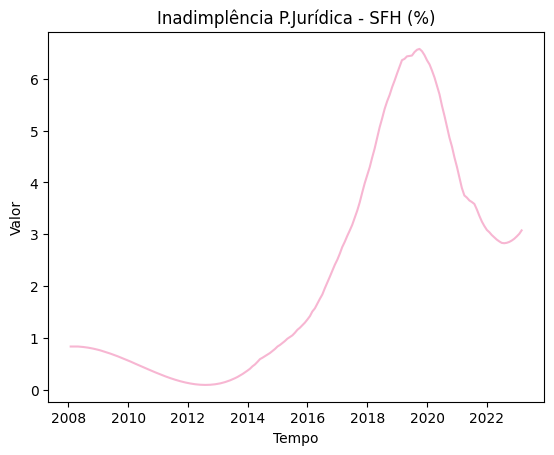

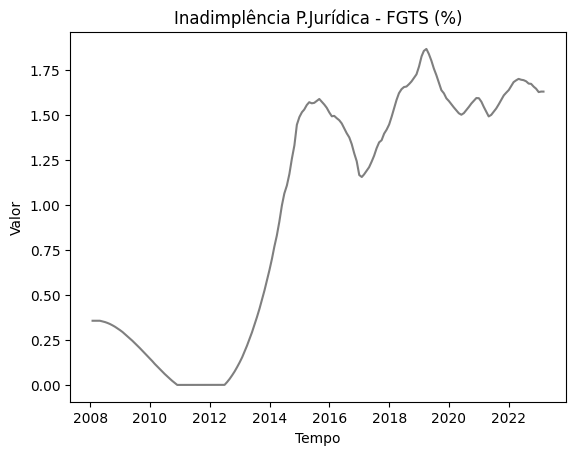

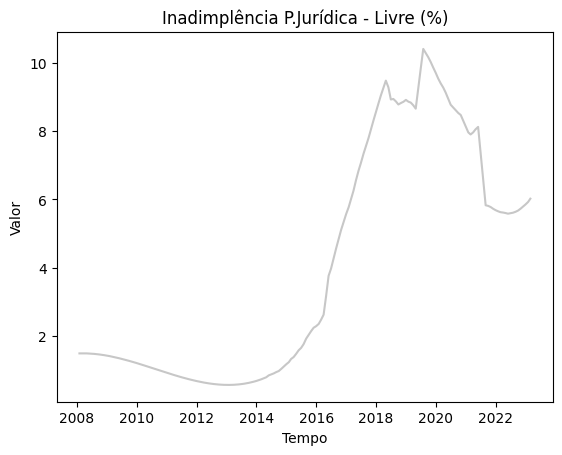

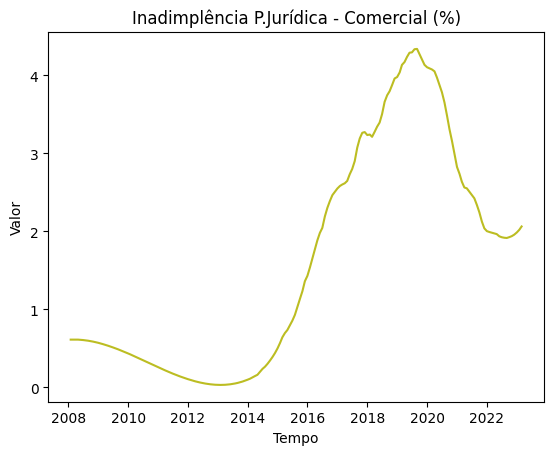

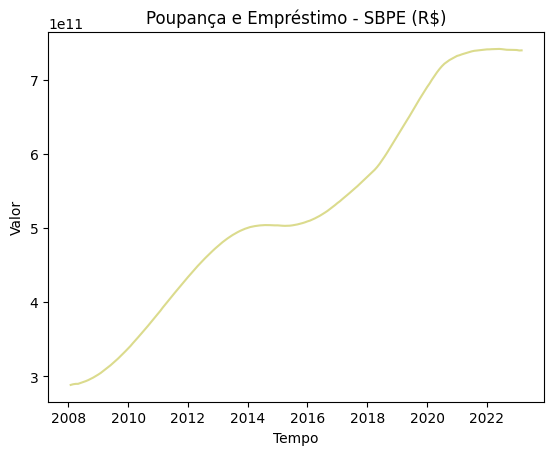

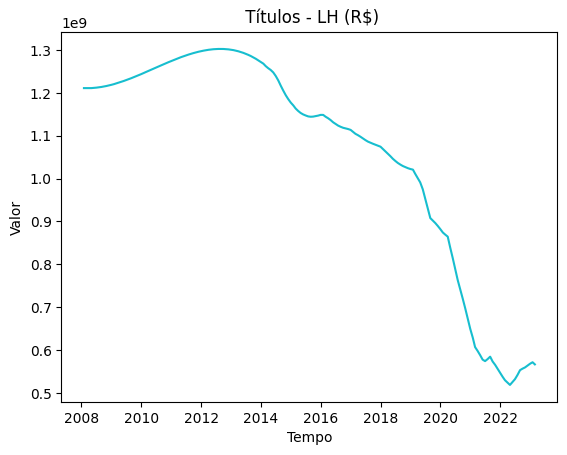

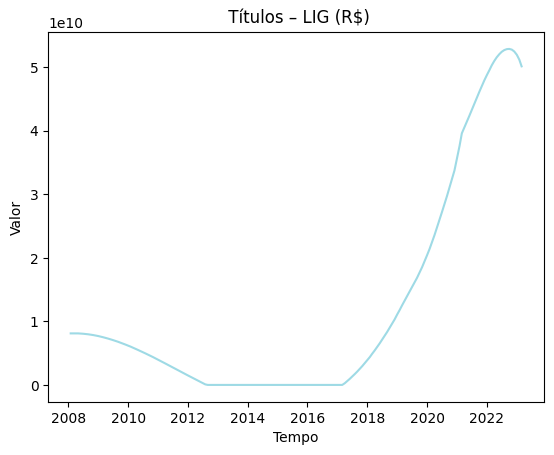

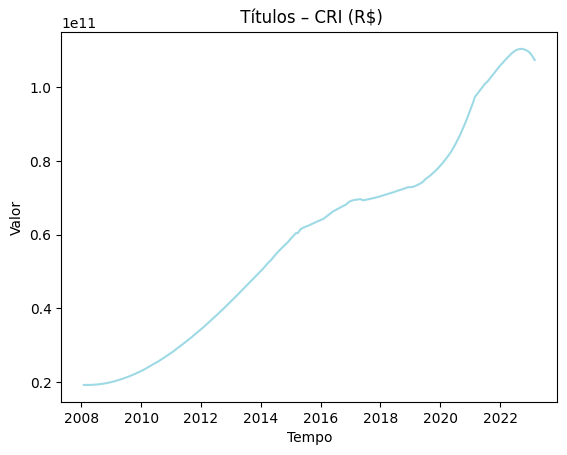

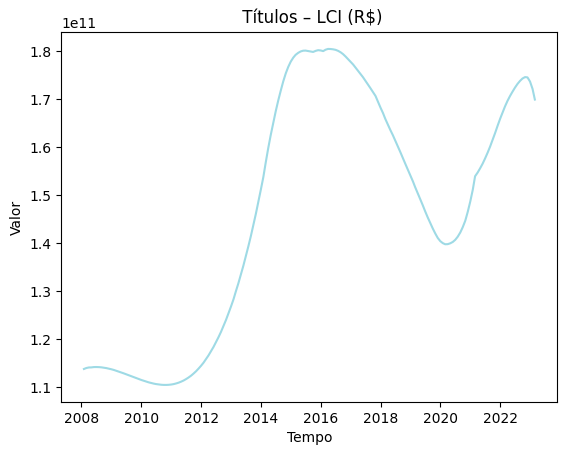

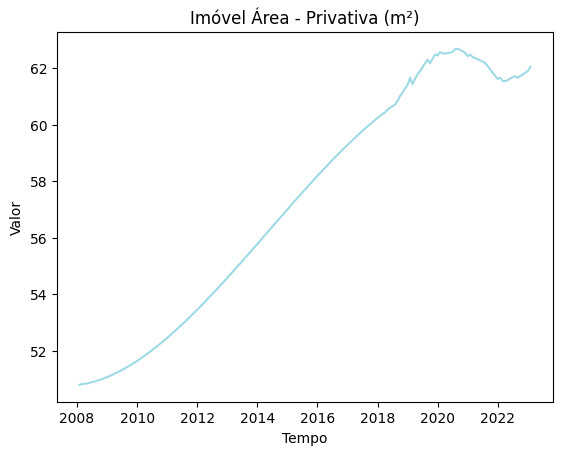

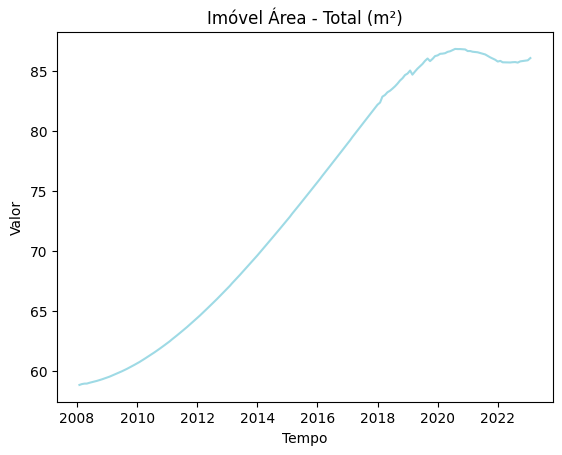

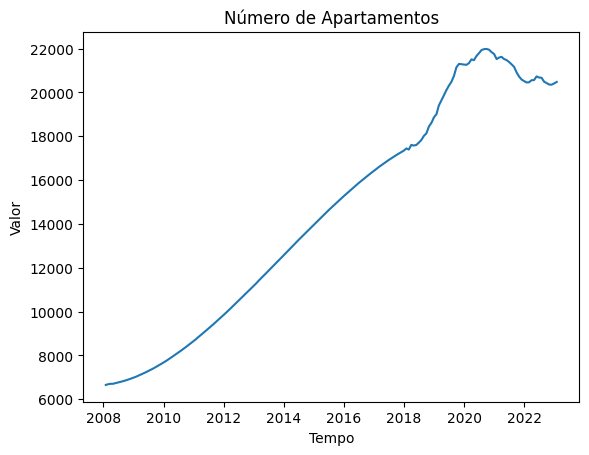

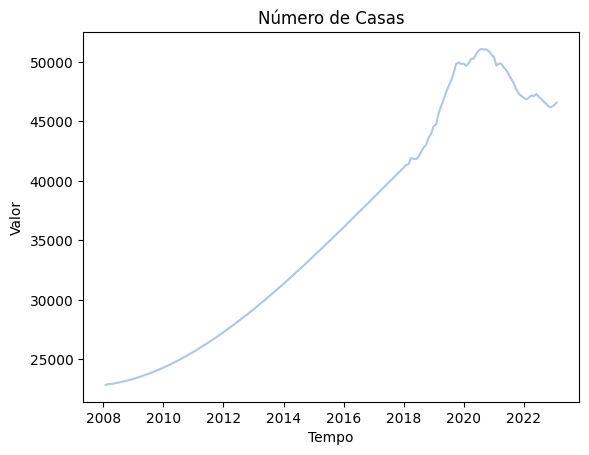

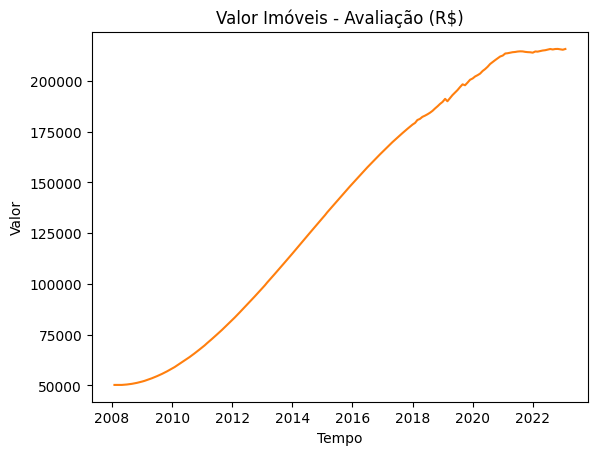

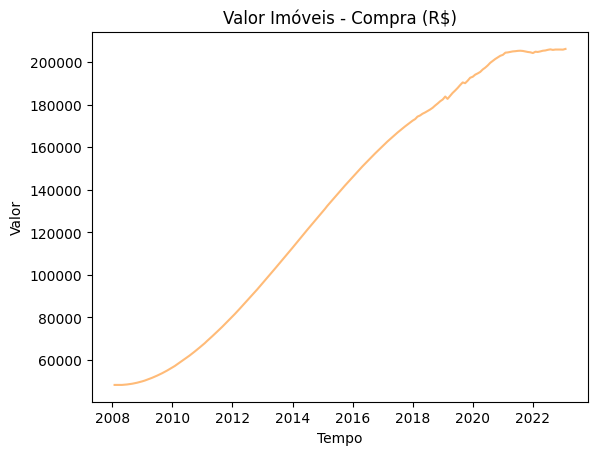

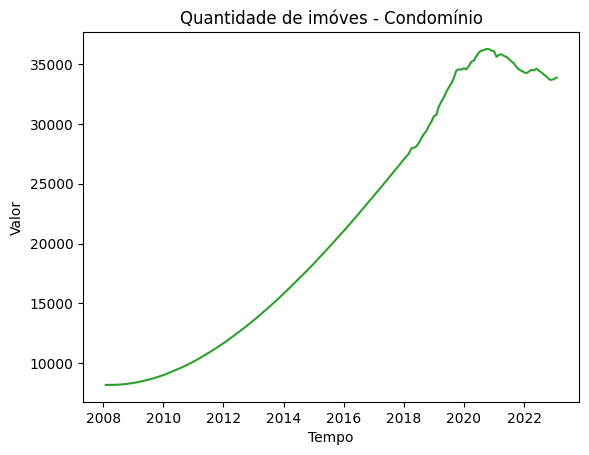

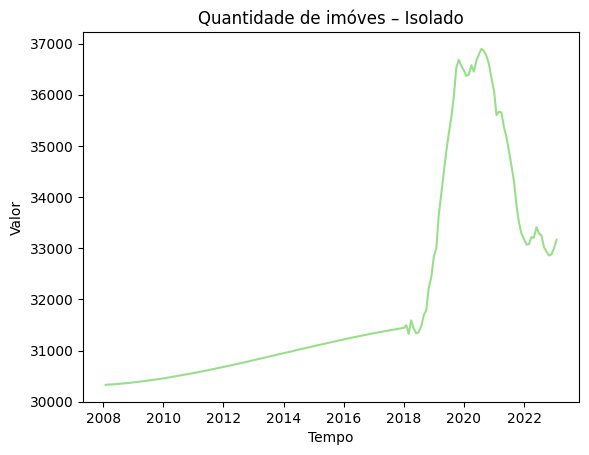

In [97]:
df_interpolated['DateTime'] = pd.to_datetime(df_interpolated['Ano'])
df_interpolated.set_index('DateTime', inplace=True)
plot_columns(df_interpolated)

In [104]:
colunas_porcentagem = ['Inadimplência - SFH (%)',
                       'Inadimplência - FGTS (%)',
                       'Inadimplência - Livre (%)',
                       'Inadimplência - Comercial (%)',
                       'Inadimplência - Home equity (%)',
                       'Inadimplência P.Jurídica - SFH (%)',
                       'Inadimplência P.Jurídica - FGTS (%)',
                       'Inadimplência P.Jurídica - Livre (%)',
                       'Inadimplência P.Jurídica - Comercial (%)']

df_by_year = df_interpolated.copy()
df_by_year = df_by_year.resample('Y').sum()
df_by_year[colunas_porcentagem] = df_by_year[colunas_porcentagem] /12
df_by_year

Contratação Comercial (Bi R$)  Contratação  Home equity (Bi R$)  \
DateTime                                                                      
2008-12-31                   5.483335e+08                      2.546644e+09   
2009-12-31                   5.302764e+08                      2.679945e+09   
2010-12-31                   5.046425e+08                      2.891930e+09   
2011-12-31                   4.854622e+08                      3.091988e+09   
2012-12-31                   4.867661e+08                      3.189506e+09   
2013-12-31                   5.225848e+08                      3.093872e+09   
2014-12-31                   5.676413e+08                      2.779340e+09   
2015-12-31                   5.179392e+08                      2.561731e+09   
2016-12-31                   4.524144e+08                      2.516859e+09   
2017-12-31                   4.213689e+08                      2.497710e+09   
2018-12-31                   4.166580e+08                      2.797145e+09   
2019-12-31                   4.462625e+08                      3.484252e+09   
2020-12-31                   5.489412e+08                      4.114911e+09   
2021-12-31                   6.638811e+08                      4.421848e+09   
2022-12-31                   7.010332e+08                      4.533216e+09   
2023-12-31                   1.149823e+08                      7.395807e+08   

            Contratação  Livre (Bi R$)  Contratação  FGTS (Bi R$)  \
DateTime                                                            
2008-12-31                1.874883e+10               2.351319e+10   
2009-12-31                2.055015e+10               2.446518e+10   
2010-12-31                2.342247e+10               2.606035e+10   
2011-12-31                2.604265e+10               2.845738e+10   
2012-12-31                2.708753e+10               3.181492e+10   
2013-12-31                2.523394e+10               3.629162e+10   
2014-12-31                1.954361e+10               4.143397e+10   
2015-12-31                1.327596e+10               4.469706e+10   
2016-12-31                1.011370e+10               4.640544e+10   
2017-12-31                8.456309e+09               4.607888e+10   
2018-12-31                7.937760e+09               4.467878e+10   
2019-12-31                1.091282e+10               4.379096e+10   
2020-12-31                1.625333e+10               4.320994e+10   
2021-12-31                1.933031e+10               4.488070e+10   
2022-12-31                1.997888e+10               4.699319e+10   
2023-12-31                3.273416e+09               7.701478e+09   

            Contratação  SFH (Bi R$)  Contratação Jurídico Comercial (Bi R$)  \
DateTime                                                                       
2008-12-31              3.993366e+10                            1.825599e+09   
2009-12-31              4.439570e+10                            2.128973e+09   
2010-12-31              5.153952e+10                            2.581963e+09   
2011-12-31              5.825126e+10                            2.924803e+09   
2012-12-31              6.141700e+10                            2.897722e+09   
2013-12-31              5.792286e+10                            2.240952e+09   
2014-12-31              4.570163e+10                            1.011496e+09   
2015-12-31              3.539769e+10                            7.138599e+08   
2016-12-31              3.407411e+10                            6.445345e+08   
2017-12-31              3.680756e+10                            8.272860e+08   
2018-12-31              4.727230e+10                            1.124213e+09   
2019-12-31              7.227332e+10                            1.266782e+09   
2020-12-31              9.809293e+10                            1.654542e+09   
2021-12-31              1.058931e+11                            2.156299e+09   
2022-12-31              1.046736e+11                            2.

In [105]:
df_csv = df_by_year.copy()
df_csv['Ano'] = df_csv.index.year
df_csv.set_index('Ano', inplace=True)
df_csv

Contratação Comercial (Bi R$)  Contratação  Home equity (Bi R$)  \
Ano                                                                     
2008                   5.483335e+08                      2.546644e+09   
2009                   5.302764e+08                      2.679945e+09   
2010                   5.046425e+08                      2.891930e+09   
2011                   4.854622e+08                      3.091988e+09   
2012                   4.867661e+08                      3.189506e+09   
2013                   5.225848e+08                      3.093872e+09   
2014                   5.676413e+08                      2.779340e+09   
2015                   5.179392e+08                      2.561731e+09   
2016                   4.524144e+08                      2.516859e+09   
2017                   4.213689e+08                      2.497710e+09   
2018                   4.166580e+08                      2.797145e+09   
2019                   4.462625e+08                      3.484252e+09   
2020                   5.489412e+08                      4.114911e+09   
2021                   6.638811e+08                      4.421848e+09   
2022                   7.010332e+08                      4.533216e+09   
2023                   1.149823e+08                      7.395807e+08   

      Contratação  Livre (Bi R$)  Contratação  FGTS (Bi R$)  \
Ano                                                           
2008                1.874883e+10               2.351319e+10   
2009                2.055015e+10               2.446518e+10   
2010                2.342247e+10               2.606035e+10   
2011                2.604265e+10               2.845738e+10   
2012                2.708753e+10               3.181492e+10   
2013                2.523394e+10               3.629162e+10   
2014                1.954361e+10               4.143397e+10   
2015                1.327596e+10               4.469706e+10   
2016                1.011370e+10               4.640544e+10   
2017                8.456309e+09               4.607888e+10   
2018                7.937760e+09               4.467878e+10   
2019                1.091282e+10               4.379096e+10   
2020                1.625333e+10               4.320994e+10   
2021                1.933031e+10               4.488070e+10   
2022                1.997888e+10               4.699319e+10   
2023                3.273416e+09               7.701478e+09   

      Contratação  SFH (Bi R$)  Contratação Jurídico Comercial (Bi R$)  \
Ano                                                                      
2008              3.993366e+10                            1.825599e+09   
2009              4.439570e+10                            2.128973e+09   
2010              5.153952e+10                            2.581963e+09   
2011              5.825126e+10                            2.924803e+09   
2012              6.141700e+10                            2.897722e+09   
2013              5.792286e+10                            2.240952e+09   
2014              4.570163e+10                            1.011496e+09   
2015              3.539769e+10                            7.138599e+08   
2016              3.407411e+10                            6.445345e+08   
2017              3.680756e+10                            8.272860e+08   
2018              4.727230e+10                            1.124213e+09   
2019              7.227332e+10                            1.266782e+09   
2020              9.809293e+10                            1.654542e+09   
2021              1.058931e+11                            2.156299e+09   
2022              1.046736e+11                            2.202753e+09   
2023              1.735804e+10                            3.523845e+08   

      Contratação Jurídico FGTS (Bi R$)  Contratação Jurídico Livre (Bi R$)  \
Ano                                                                           
2008                       6.113879e+08                        5.

In [106]:
df_csv.to_csv('2008_01_imob.csv', index=True)